# Model B: Disease Progression (Binary: Stage 1+2 (Class 0) vs Stage 3 (Class 1)) 

## This model predicts the exact Stage (1, 2, or 3) of Liver Cirrhosis.


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import optuna
import joblib
import os
import json

optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

## 0. Load Data

In [27]:
df = pd.read_csv('./data/liver_cirrhosis_deduped.csv')

# Drop ID if exists
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

df = df.dropna(subset=['Stage'])

# Filter: Only Stages 1, 2, 3 (no Stage 4)
# Model B explicitly excludes Stage 4 to focus on progression from early to advanced (but not terminal)
df_b = df[df['Stage'].isin([1, 2, 3])].copy()

print(f"Filtered Shape (Stages 1,2,3 only): {df_b.shape}")
print("\nStage Distribution:")
print(df_b['Stage'].value_counts().sort_index())

Filtered Shape (Stages 1,2,3 only): (8957, 19)

Stage Distribution:
Stage
1    2771
2    3062
3    3124
Name: count, dtype: int64


## 1. Target Definition 
 **Binary: Stage 1+2 (Early) vs Stage 3 (Advanced)**

In [28]:
# Target: Stage as-is (1, 2, 3)
# Adjust to 0, 1, 2 for sklearn/XGBoost
# Target: Binary (Stages 1&2 vs 3)
# 1, 2 -> 0; 3 -> 1
df_b['Stage'] = df_b['Stage'].apply(lambda x: 0 if x in [1, 2] else 1)

print("Binary Target Distribution (Model B):")
print(df_b['Stage'].value_counts().sort_index())
print(f"\nClass 0 (Stage 1+2): {(df_b['Stage'] == 0).sum()}")
print(f"Class 1 (Stage 3): {(df_b['Stage'] == 1).sum()}")


Binary Target Distribution (Model B):
Stage
0    5833
1    3124
Name: count, dtype: int64

Class 0 (Stage 1+2): 5833
Class 1 (Stage 3): 3124


## 2. Log Transformation + Winsorization (Model B Flow)

In [29]:
# Log Transformation + Winsorization
log_transform_cols = ['Bilirubin', 'Copper', 'Alk_Phos', 'Tryglicerides', 'SGOT', 'Prothrombin', 'Cholesterol']

print("Step 1: Applying Log Transformation...")
df_transformed_b = df_b.copy()
for col in log_transform_cols:
    if col in df_transformed_b.columns:
        df_transformed_b[col] = np.log1p(df_transformed_b[col])
        print(f"  - {col}: log-transformed")

winsor_cols = log_transform_cols

# Apply Stage-Specific Winsorization
clipped_df = df_transformed_b.copy()
stages = clipped_df['Stage'].unique()

# print("\nStep 2: Applying Stage-specific Winsorization (Model B)...")

# for col in winsor_cols:
#     if col in clipped_df.columns:
#         stage_data = clipped_df.loc[ :,col]
#         Q1 = stage_data.quantile(0.25)
#         Q3 = stage_data.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         clipped_df.loc[:, col] = stage_data.clip(lower=lower_bound, upper=upper_bound)
# print("Winsorization complete!")

df_b_clean = clipped_df

Step 1: Applying Log Transformation...
  - Bilirubin: log-transformed
  - Copper: log-transformed
  - Alk_Phos: log-transformed
  - Tryglicerides: log-transformed
  - SGOT: log-transformed
  - Prothrombin: log-transformed
  - Cholesterol: log-transformed


Visualizing Preprocessing Effects (Raw vs Log+Winsorized)


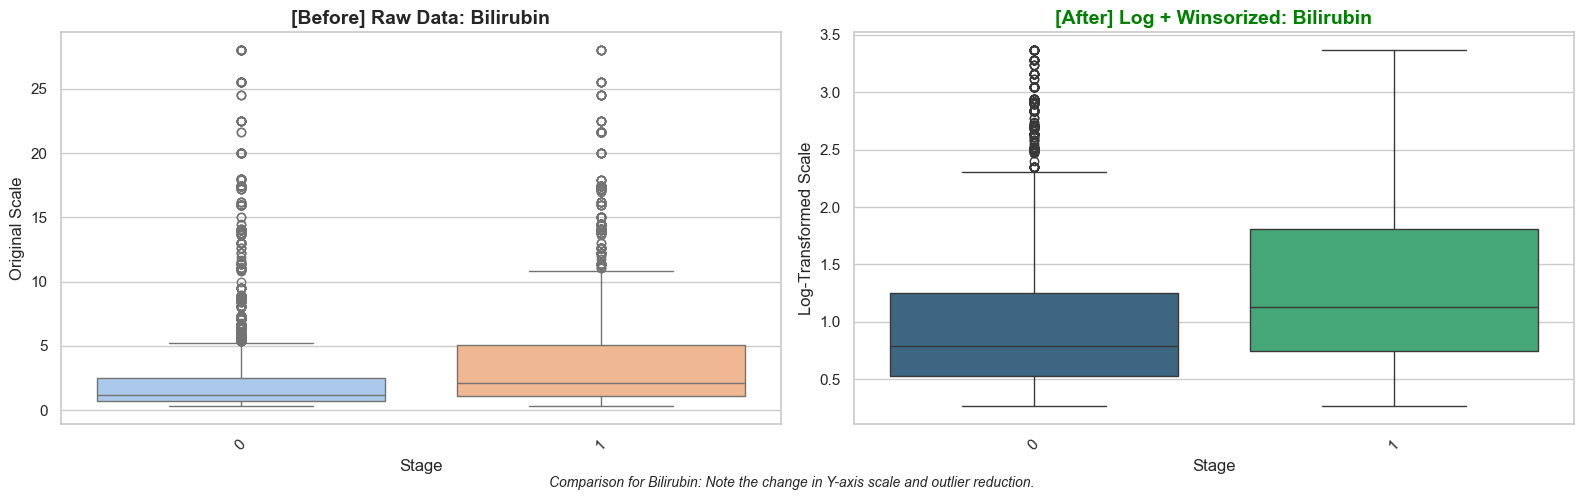

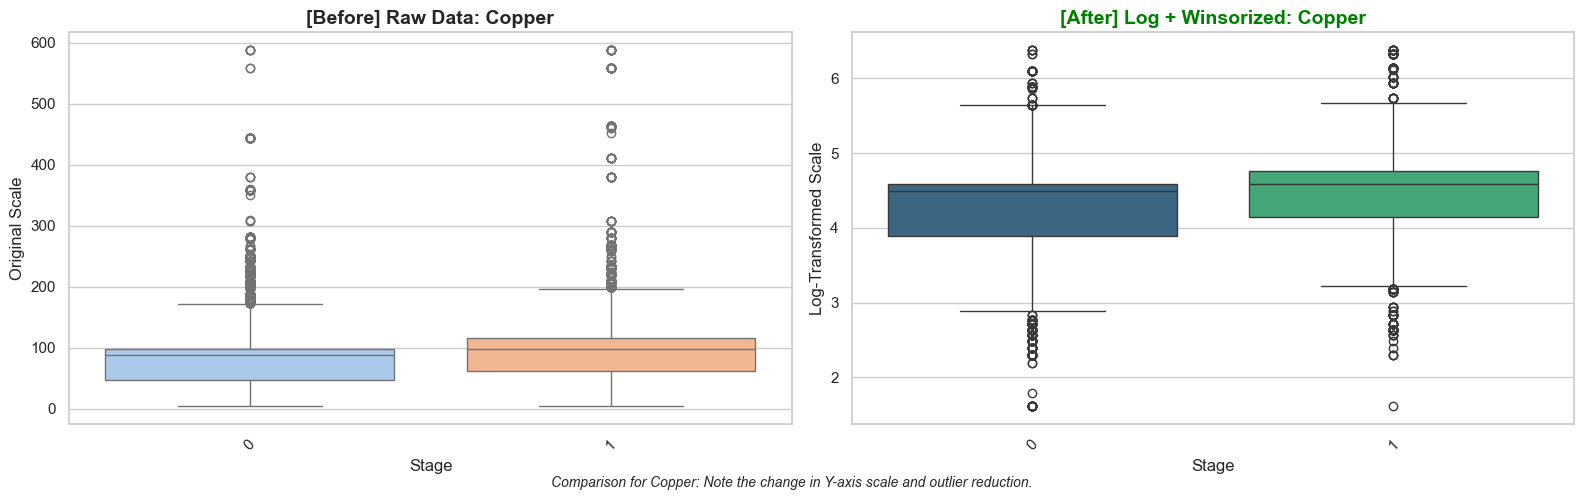

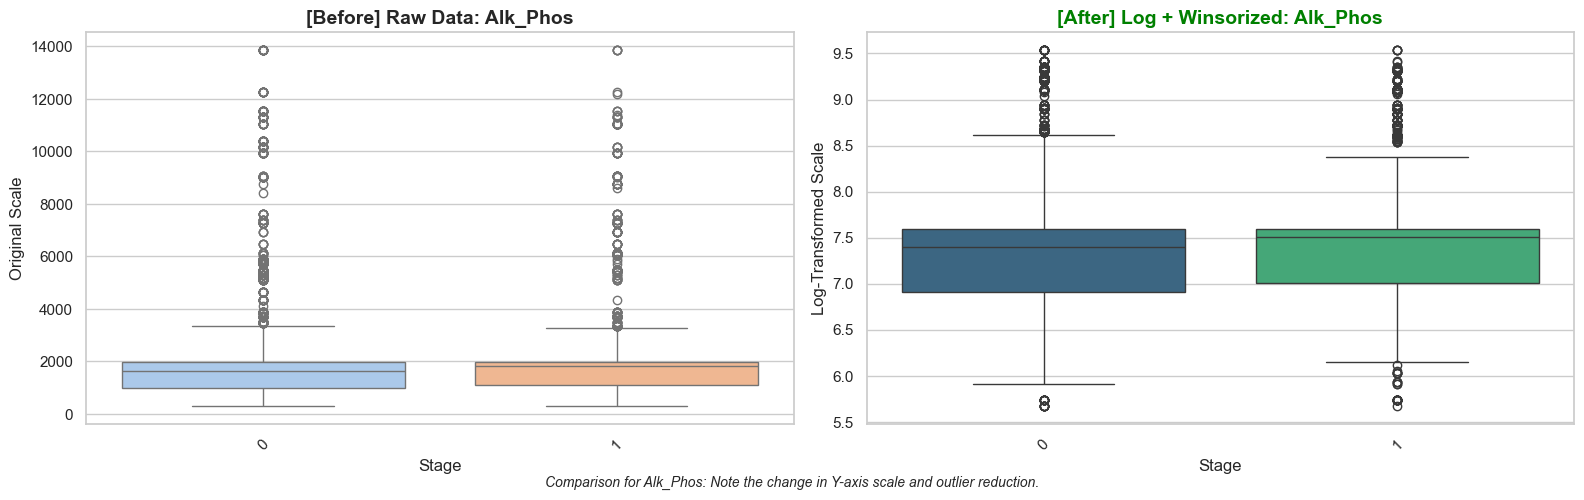

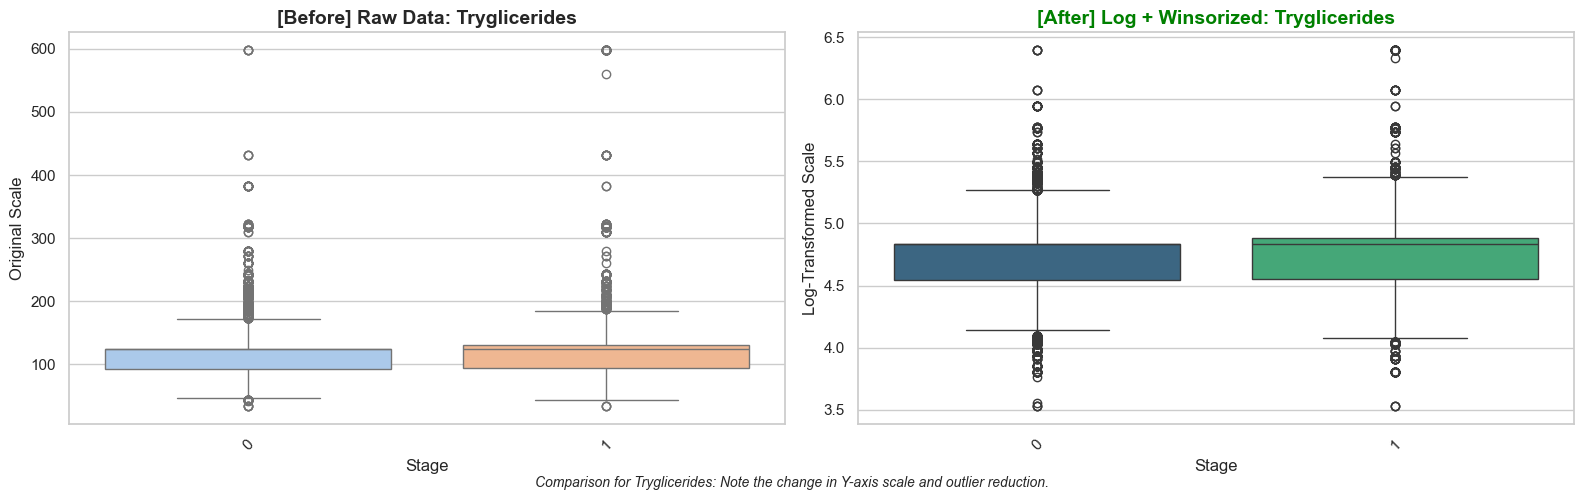

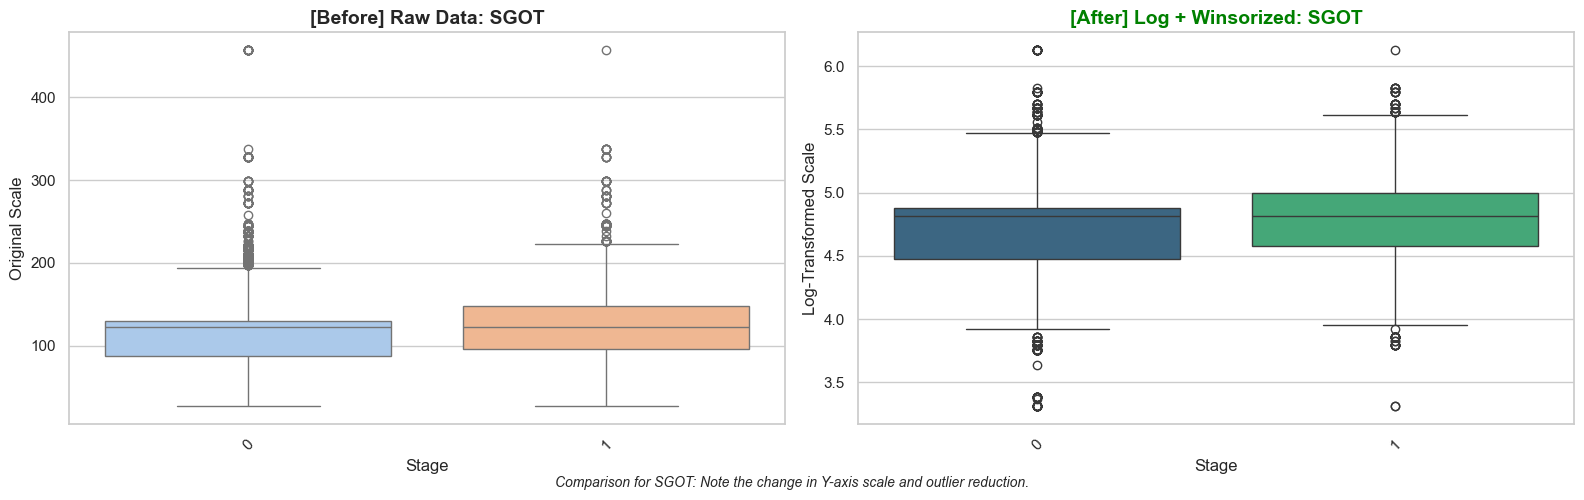

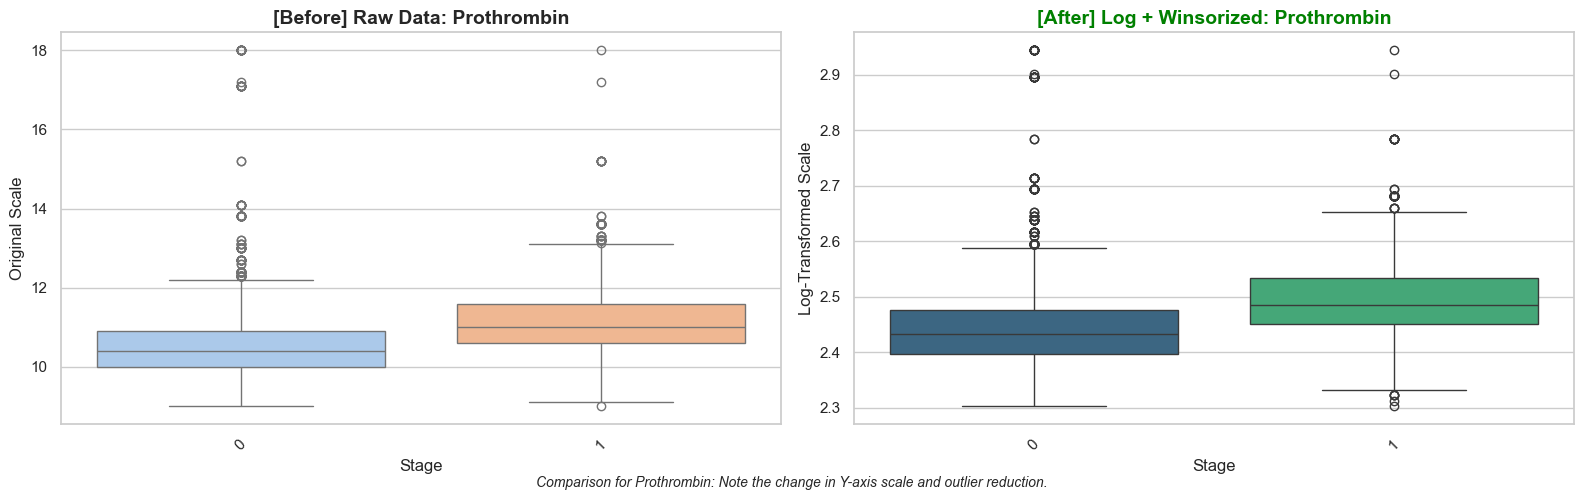

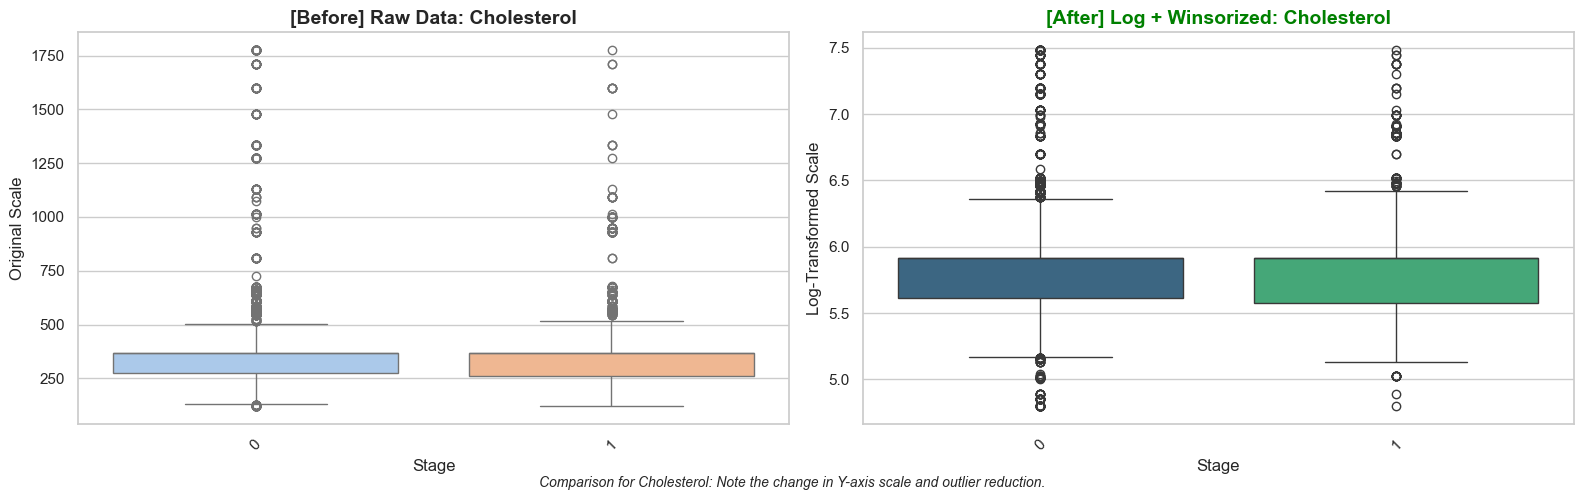

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정
sns.set(style="whitegrid")

def plot_before_after_comparison(df_before, df_after, columns, stage_col='Stage'):
    """
    변수별로 Log 변환 + 윈저라이징 전후의 분포를 시각화합니다.
    왼쪽: 원본 데이터 (df_before)
    오른쪽: 전처리 후 데이터 (df_after)
    """
    # Stage 순서 정렬 (그래프 일관성 위함)
    stage_order = sorted(df_before[stage_col].unique())

    for col in columns:
        if col not in df_before.columns or col not in df_after.columns:
            continue

        # 1행 2열의 서브플롯 생성 (왼쪽: Before, 오른쪽: After)
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # --- [왼쪽] Before: Raw Data ---
        # Boxplot으로 이상치와 분포 확인
        sns.boxplot(data=df_before, x=stage_col, y=col, order=stage_order, 
                    ax=axes[0], palette="pastel", showfliers=True) # showfliers=True: 이상치 표시
        
        # 제목 및 스타일
        axes[0].set_title(f'[Before] Raw Data: {col}', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Original Scale')
        axes[0].tick_params(axis='x', rotation=45)

        # --- [오른쪽] After: Log + Winsorized ---
        sns.boxplot(data=df_after, x=stage_col, y=col, order=stage_order, 
                    ax=axes[1], palette="viridis", showfliers=True)
        
        # 제목 및 스타일
        axes[1].set_title(f'[After] Log + Winsorized: {col}', fontsize=14, fontweight='bold', color='green')
        axes[1].set_ylabel('Log-Transformed Scale')
        axes[1].tick_params(axis='x', rotation=45)

        # 텍스트 추가 (어떤 처리가 들어갔는지)
        plt.figtext(0.5, 0.01, f"Comparison for {col}: Note the change in Y-axis scale and outlier reduction.", 
                    ha="center", fontsize=10, style='italic')

        plt.tight_layout()
        plt.show()

# --- 실행 부분 ---
# 비교할 컬럼 목록 (코드에 있는 변수 그대로 사용)
target_cols = ['Bilirubin', 'Copper', 'Alk_Phos', 'Tryglicerides', 'SGOT', 'Prothrombin', 'Cholesterol']

print("="*60)
print("Visualizing Preprocessing Effects (Raw vs Log+Winsorized)")
print("="*60)

plot_before_after_comparison(df_b, df_b_clean, target_cols)

## 3. Feature Engineering

In [31]:
def medical_feature_engineering(df_input):
    df_eng = df_input.copy()
    
    # Age conversion
    df_eng['Age_Year'] = df_eng['Age'] / 365.25
    
    # Unit conversions
    df_eng['bili_umolL'] = df_eng['Bilirubin'] * 17.1
    df_eng['alb_gL'] = df_eng['Albumin'] * 10
    df_eng['plt_1000uL'] = df_eng['Platelets'] / 1000
    
    # ALBI Score
    df_eng['ALBI'] = (np.log10(df_eng['bili_umolL']) * 0.66) + (df_eng['alb_gL'] * -0.085)
    
    # PALBI Score  
    df_eng['PALBI'] = (df_eng['ALBI'] * 1.0) + (df_eng['plt_1000uL'] * -0.04)
    
    # APRI
    df_eng['APRI'] = (df_eng['SGOT'] / 40) / df_eng['plt_1000uL']
    
    # FIB-4
    df_eng['FIB4'] = (df_eng['Age_Year'] * df_eng['SGOT']) / (df_eng['plt_1000uL'] * np.sqrt(df_eng['Bilirubin']))
    
    # Bilirubin/Platelets
    df_eng['Bili_Platelet_Ratio'] = df_eng['Bilirubin'] / (df_eng['Platelets'] + 1)
    
    # Copper×Bilirubin
    df_eng['Copper_Bili_Interaction'] = df_eng['Copper'] * df_eng['Bilirubin']
    
    return df_eng

df_b_fe = medical_feature_engineering(df_b_clean)
print("Medical features engineered!")
print(df_b_fe[['ALBI', 'PALBI', 'APRI', 'FIB4']].describe())

Medical features engineered!
              ALBI        PALBI         APRI         FIB4
count  8957.000000  8957.000000  8957.000000  8957.000000
mean     -2.174239    -2.184362     0.549853  1172.344067
std       0.409204     0.409706     0.256153   645.721150
min      -3.394745    -3.409185     0.136059   203.331537
25%      -2.465835    -2.472358     0.382103   724.887556
50%      -2.178418    -2.191024     0.477732  1030.972948
75%      -1.930265    -1.940381     0.637719  1442.811175
max      -0.568093    -0.575693     2.349194  5507.561403


## 3.5. Exploratory Data Analysis (EDA)

EXPLORATORY DATA ANALYSIS - ALL FEATURES (Model B)

Total numeric features: 21
Features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age_Year', 'bili_umolL', 'alb_gL', 'plt_1000uL', 'ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']


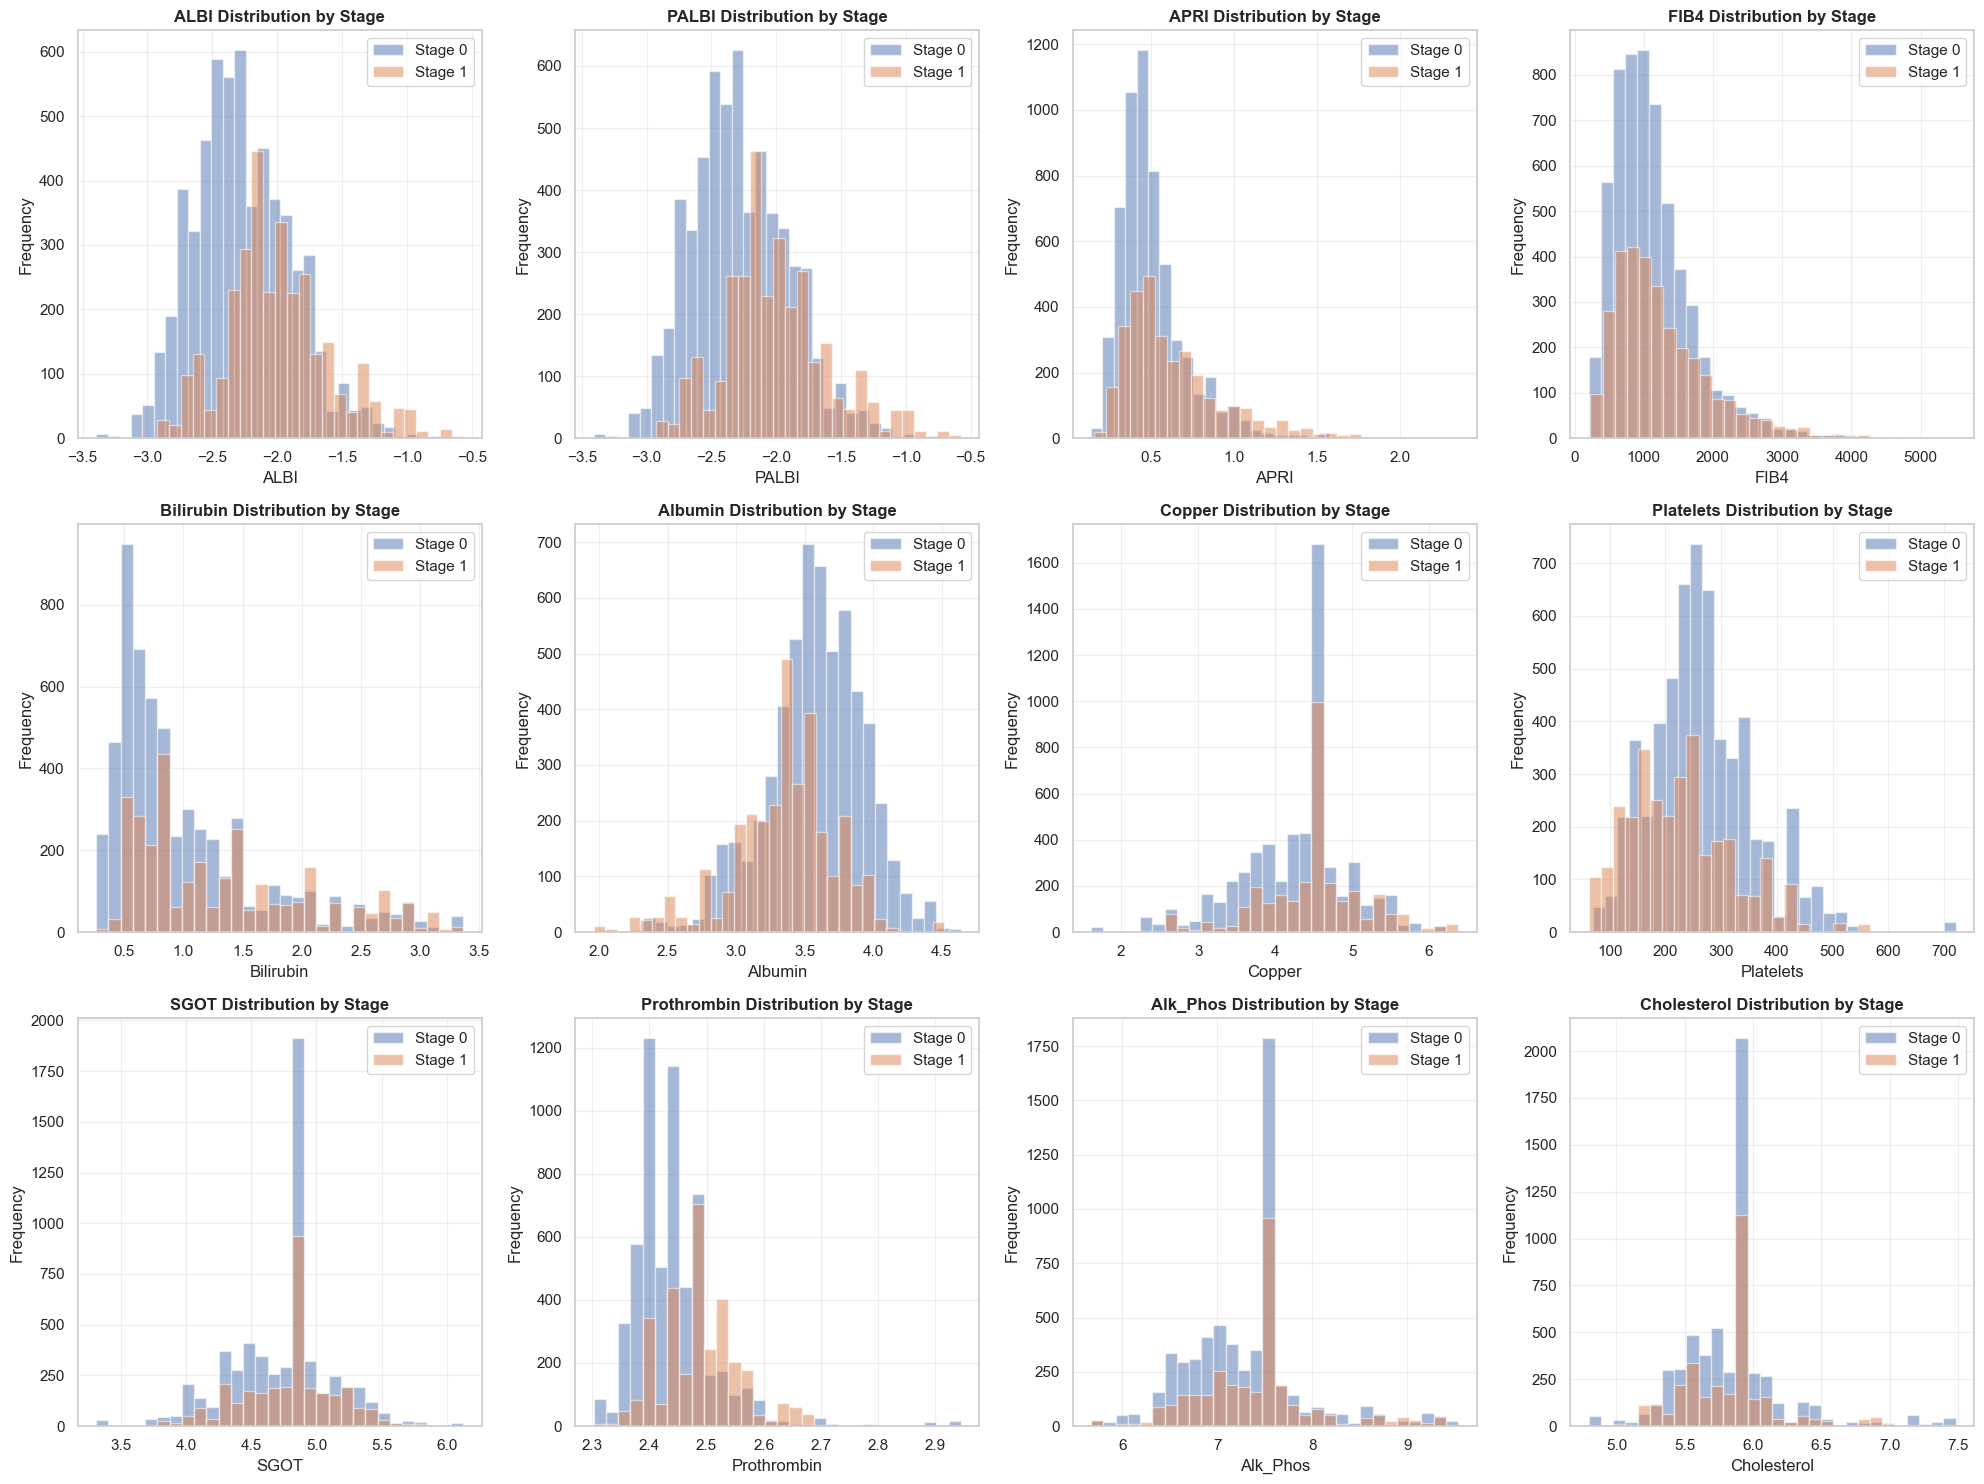


Correlation Analysis - Engineered Medical Features


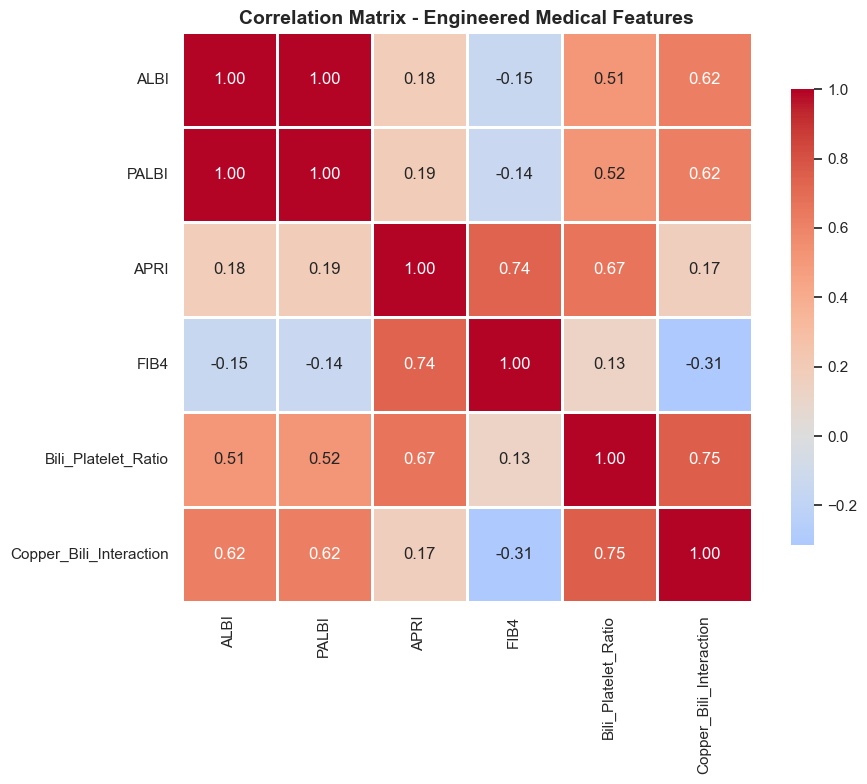


EDA Complete!


In [32]:
# EDA on All Features
print("="*70)
print("EXPLORATORY DATA ANALYSIS - ALL FEATURES (Model B)")
print("="*70)

# Get all numeric features after feature engineering
numeric_features = df_b_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target and stage columns
numeric_features = [col for col in numeric_features if col not in ['Stage', 'Target', 'Is_Advanced']]

print(f"\nTotal numeric features: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# Distribution plots for key medical features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

key_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bilirubin', 'Albumin', 
                'Copper', 'Platelets', 'SGOT', 'Prothrombin', 'Alk_Phos', 'Cholesterol']

for idx, feature in enumerate(key_features[:12]):
    if feature in df_b_fe.columns:
        for stage in [0,1]:
            stage_data = df_b_fe[df_b_fe['Stage'] == stage][feature].dropna()
            axes[idx].hist(stage_data, alpha=0.5, label=f'Stage {stage}', bins=30)
        axes[idx].set_title(f'{feature} Distribution by Stage', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap for engineered features
print("\nCorrelation Analysis - Engineered Medical Features")
engineered_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']
if all(feat in df_b_fe.columns for feat in engineered_features):
    corr_matrix = df_b_fe[engineered_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Engineered Medical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("EDA Complete!")
print("="*70)


## 4. Preprocessing & Data Splitting

In [33]:
target_col = 'Stage'
y = df_b_fe[target_col]

# Exclude intermediate variables
drop_cols = ['N_Days','Status','Drug','Age','Sex','Stage', 'Age_Year', 'bili_umolL', 'alb_gL', 'plt_1000uL']
X = df_b_fe.drop(columns=[col for col in drop_cols if col in df_b_fe.columns])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train-Test Split (Stratified)
# 3-Way Split: Train (60%), Calib (20%), Test (20%)
# First, split out Test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Then, split remaining 80% into Train (75% of temp = 60% total) and Calib (25% of temp = 20% total)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train size: {X_train.shape[0]} (for Base Model Training)")
print(f"Calib size: {X_calib.shape[0]} (for Calibration/Threshold Tuning)")
print(f"Test size: {X_test.shape[0]} (for Final Evaluation)")

# Preprocessor
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')


Features shape: (8957, 19)
Target shape: (8957,)
Train size: 5373 (for Base Model Training)
Calib size: 1792 (for Calibration/Threshold Tuning)
Test size: 1792 (for Final Evaluation)

Numeric columns: 15
Categorical columns: 4


In [34]:
X.head()

,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,ALBI,PALBI,APRI,FIB4,Bili_Platelet_Ratio,Copper_Bili_Interaction
0,N,Y,N,N,0.405465,5.010635,4.04,5.429346,6.395262,3.983413,4.060443,256.0,2.388763,-2.878973,-2.889213,0.389005,1237.646606,0.001578,2.201410
1,Y,N,Y,N,0.405465,5.393628,3.93,3.135494,6.498282,3.828641,4.330733,220.0,2.468100,-2.785473,-2.794273,0.435073,1475.876561,0.001835,1.271334
2,N,N,N,N,0.405465,5.771441,3.54,3.951244,7.126087,4.815836,4.394449,225.0,2.397895,-2.453973,-2.462973,0.535093,1089.525107,0.001794,1.602091
3,N,N,N,N,0.530628,5.545177,3.74,3.178054,6.932448,4.363099,4.077537,151.0,2.415914,-2.546861,-2.552901,0.722367,1788.327930,0.003491,1.686365
4,N,Y,N,N,1.064711,6.188264,3.54,4.317488,6.959399,4.695925,4.700480,151.0,2.525729,-2.177250,-2.183290,0.777471,1790.514496,0.007005,4.596876


In [35]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_vif(df):
    # 1. 수치형 데이터만 골라내기 (문자열 등은 VIF 계산 불가)
    df_numeric = df.select_dtypes(include=[np.number])
    
    # 2. 결측치(NaN)가 있으면 에러가 나므로 제거 (필요시 fillna 등으로 대체 가능)
    df_numeric = df_numeric.dropna()
    
    # 3. 상수항(Intercept) 추가
    df_with_const = add_constant(df_numeric)
    
    # 4. 반복문으로 모든 컬럼의 VIF 계산
    vif_list = []
    for i in range(df_with_const.shape[1]):
        vif_list.append([
            df_with_const.columns[i], 
            variance_inflation_factor(df_with_const.values, i)
        ])
    
    # 5. 결과 정리 (상수항 제외 & 높은 순 정렬)
    vif_df = pd.DataFrame(vif_list, columns=['Feature', 'VIF'])
    vif_df = vif_df[vif_df['Feature'] != 'const']  # 상수항 제거
    vif_df = vif_df.sort_values(by='VIF', ascending=False) # 내림차순 정렬
    
    return vif_df

get_vif(X)

ModuleNotFoundError: No module named 'statsmodels'

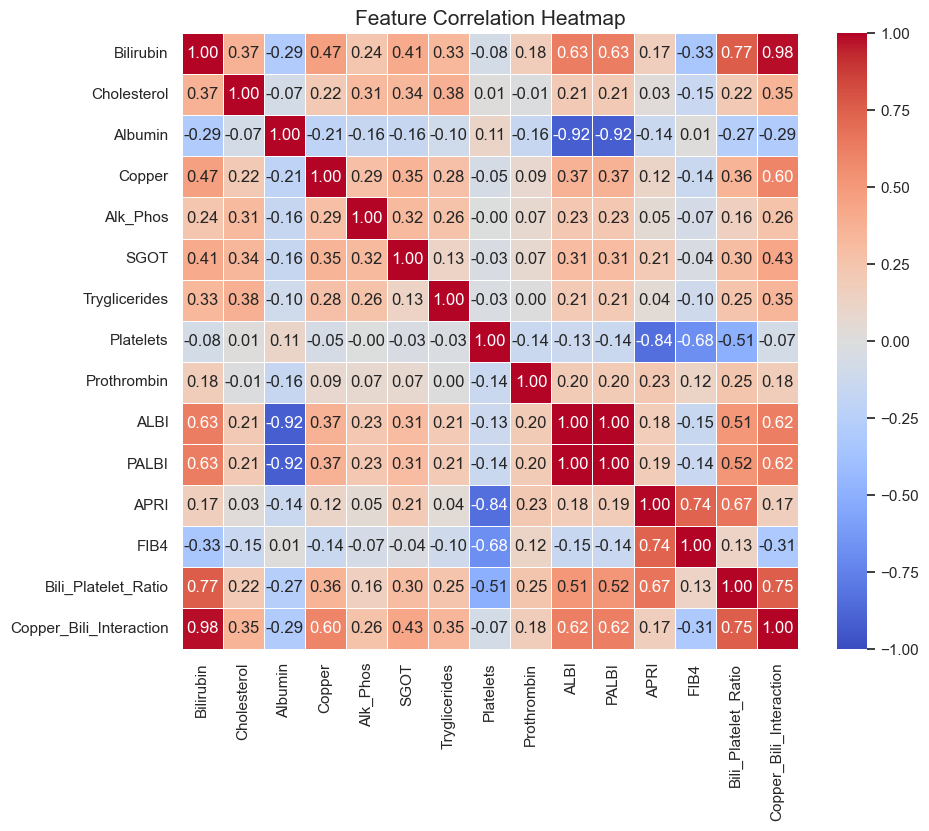

In [36]:
def plot_heatmap(df):
    """
    데이터프레임을 받아서 '수치형 변수'만 자동으로 필터링하여 
    상관관계 히트맵을 그려주는 함수.
    문자열이나 'N' 같은 값이 섞여 있어도 에러가 나지 않습니다.
    """
    # 1. 수치형(number) 컬럼만 선택 (문자열, 날짜 등 자동 제외)
    df_numeric = df.select_dtypes(include=['number'])
    
    # 2. 예외 처리: 수치형 변수가 2개 미만이면 상관관계 도출 불가
    if df_numeric.shape[1] < 2:
        print("⚠ 경고: 상관관계를 계산할 수치형 변수가 부족합니다. (2개 이상 필요)")
        return

    # 3. 상관계수 계산 (NaN이 있어도 corr() 함수가 알아서 처리함)
    corr_matrix = df_numeric.corr()
    
    # 4. 시각화 설정
    plt.figure(figsize=(10, 8)) # 그래프 크기 설정
    
    sns.heatmap(data=corr_matrix, 
                annot=True,       # 칸 안에 상관계수 수치 표시
                fmt='.2f',        # 소수점 둘째 자리까지 표시
                cmap='coolwarm',  # 색상: 파랑(음의 상관) ~ 빨강(양의 상관)
                vmin=-1, vmax=1,  # 색상 범위를 -1 ~ 1로 고정
                linewidths=0.5,   # 칸 사이 구분선
                square=True)      # 칸을 정사각형으로 유지
    
    plt.title('Feature Correlation Heatmap', fontsize=15)
    plt.show()
    return

plot_heatmap(X)

## 5. Hyperparameter Tuning (Optuna)

In [38]:
# 1. Random Forest Tuning
def objective_rf(trial):
    # Search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', model)
    ])
    
    # Stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    
    return scores.mean()



# 2. XGBoost Tuning
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'eval_metric': 'logloss', # Multi-class logloss
        'objective': 'binary:logistic', # Multi-class
    }
    
    model = XGBClassifier(**params)
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    
    return scores.mean()



# 3. LightGBM Tuning
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1
    }
    
    model = LGBMClassifier(**params)
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    
    return scores.mean()



In [39]:
import json
import os

BEST_PARAMS_JSON = './saved_models/model_b_dedupled_binary_best_params.json'

def load_or_tune_rf():
    print('Checking for best params json...')
    if os.path.exists(BEST_PARAMS_JSON):
        try:
            with open(BEST_PARAMS_JSON, 'r') as f:
                all_params = json.load(f)
                if 'random_forest' in all_params:
                    print(f'Loading RF params from {BEST_PARAMS_JSON}...')
                    return all_params['random_forest']
        except Exception as e:
            print(f'Error reading json: {e}')
    # Fallback to tuning if json fails or missing
    print('Tuning Random Forest...')
    study_rf = optuna.create_study(direction='maximize')
    study_rf.optimize(objective_rf, n_trials=30)
    print('Best RF Params:', study_rf.best_params)
    return study_rf.best_params

def load_or_tune_xgb():
    if os.path.exists(BEST_PARAMS_JSON):
        try:
            with open(BEST_PARAMS_JSON, 'r') as f:
                all_params = json.load(f)
                if 'xgboost' in all_params:
                    print(f'Loading XGB params from {BEST_PARAMS_JSON}...')
                    return all_params['xgboost']
        except Exception as e:
            print(f'Error reading json: {e}')
    print('Tuning XGBoost...')
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=30)
    print('Best XGB Params:', study_xgb.best_params)
    return study_xgb.best_params

def load_or_tune_lgbm():
    if os.path.exists(BEST_PARAMS_JSON):
        try:
            with open(BEST_PARAMS_JSON, 'r') as f:
                all_params = json.load(f)
                if 'lightgbm' in all_params:
                    print(f'Loading LightGBM params from {BEST_PARAMS_JSON}...')
                    return all_params['lightgbm']
        except Exception as e:
            print(f'Error reading json: {e}')
    print('Tuning LightGBM...')
    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective_lgbm, n_trials=30)
    print('Best LGBM Params:', study_lgbm.best_params)
    return study_lgbm.best_params

best_rf_params = load_or_tune_rf()
print(f"Best RF Params: {best_rf_params}")
best_xgb_params = load_or_tune_xgb()  
print(f"Best XGB Params: {best_xgb_params}")
best_lgbm_params = load_or_tune_lgbm()
print(f"Best LGBM Params: {best_lgbm_params}")

Checking for best params json...
Tuning Random Forest...
Best RF Params: {'n_estimators': 460, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Best RF Params: {'n_estimators': 460, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Tuning XGBoost...
Best XGB Params: {'n_estimators': 358, 'max_depth': 9, 'learning_rate': 0.08549709040070744, 'subsample': 0.9986714710344716, 'colsample_bytree': 0.7720570353807048}
Best XGB Params: {'n_estimators': 358, 'max_depth': 9, 'learning_rate': 0.08549709040070744, 'subsample': 0.9986714710344716, 'colsample_bytree': 0.7720570353807048}
Tuning LightGBM...
Best LGBM Params: {'n_estimators': 486, 'max_depth': 14, 'learning_rate': 0.1728452698477596, 'num_leaves': 37, 'subsample': 0.7922724582934423, 'colsample_bytree': 0.6056038787266721}
Best LGBM Params: {'n_estimators': 486, 'max_depth': 14, 'learning_rate': 0.1728452698477596, 'num_leaves': 37, 'subsample': 0.79227245829344

## 6. Ensemble Model (Voting)

Training Ensemble (Model B - Multi-class)...

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1167
           1       0.94      0.89      0.92       625

    accuracy                           0.94      1792
   macro avg       0.94      0.93      0.94      1792
weighted avg       0.94      0.94      0.94      1792



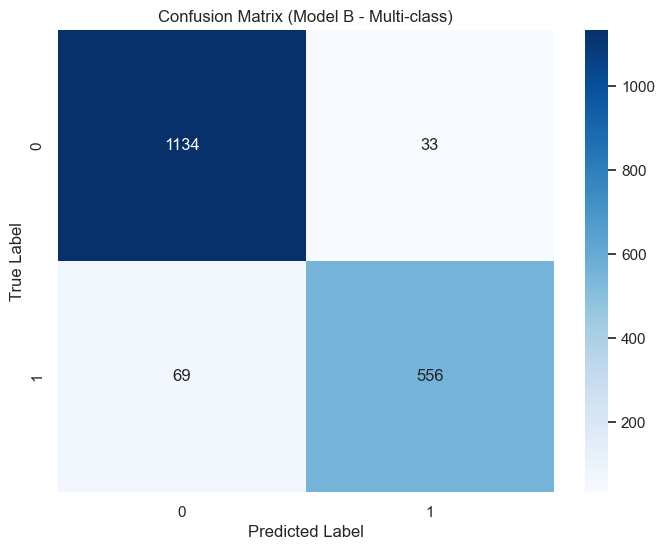


Macro F1-Score: 0.9365


In [42]:
# Final Ensemble (Model B - Multi-class)
model_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('lgbm', model_lgbm)],
    voting='soft'
)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    
    ('ensemble', ensemble)
])

print("Training Ensemble (Model B - Multi-class)...")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)

print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix (Model B - Multi-class)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Macro F1
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score: {f1_macro:.4f}")

## 6.5. Individual Model Performance & Saving

INDIVIDUAL MODEL PERFORMANCE COMPARISON (Model B)

1️⃣ Random Forest Classifier
  Accuracy: 0.9102
  F1-Score (Macro): 0.8994

2️⃣ XGBoost Classifier
  Accuracy: 0.9420
  F1-Score (Macro): 0.9354

3️⃣ LightGBM Classifier
  Accuracy: 0.9470
  F1-Score (Macro): 0.9410

4️⃣ Voting Ensemble (Soft Voting)
  Accuracy: 0.9431
  F1-Score (Macro): 0.9365

PERFORMANCE COMPARISON TABLE
                 Accuracy  F1-Score (Macro)  F1-Score (Weighted)
Random Forest    0.910156          0.899439             0.909369
XGBoost          0.941964          0.935380             0.941619
LightGBM         0.946987          0.940996             0.946682
Voting Ensemble  0.943080          0.936471             0.942669


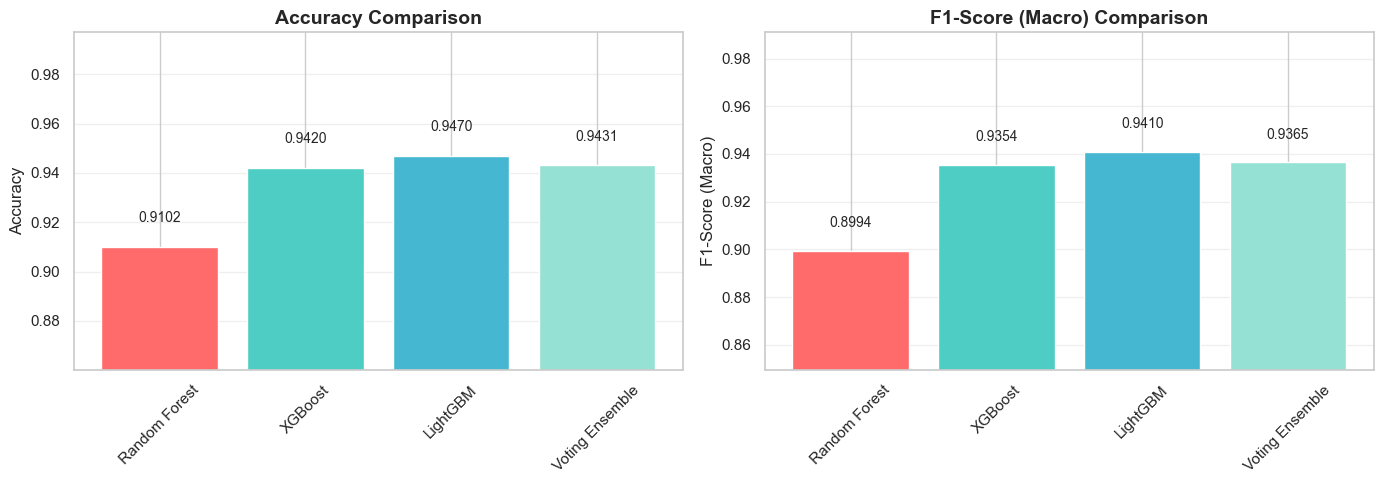


🏆 Best Model: LightGBM (F1-Score: 0.9410)

SAVING MODELS FOR SERVING

Saving individual models...
✅ Saved: model_b_random_forest.pkl
✅ Saved: model_b_xgboost.pkl
✅ Saved: model_b_lightgbm.pkl
✅ Saved: model_b_voting_ensemble.pkl
✅ Saved: model_b_preprocessor.pkl
✅ Saved: model_b_best_params.json

All models saved successfully to ./saved_models/


In [44]:
print("="*70)
print("INDIVIDUAL MODEL PERFORMANCE COMPARISON (Model B)")
print("="*70)

# Train and evaluate each model individually
individual_results = {}

# 1. Random Forest
print("\n1️⃣ Random Forest Classifier")
model_rf_individual = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),

    ('classifier', model_rf_individual)
])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

individual_results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1-Score (Macro)': f1_score(y_test, y_pred_rf, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_rf, average='weighted')
}
print(f"  Accuracy: {individual_results['Random Forest']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['Random Forest']['F1-Score (Macro)']:.4f}")

# 2. XGBoost
print("\n2️⃣ XGBoost Classifier")
model_xgb_individual = XGBClassifier(**best_xgb_params, random_state=42)
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    
    ('classifier', model_xgb_individual)
])
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

individual_results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'F1-Score (Macro)': f1_score(y_test, y_pred_xgb, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_xgb, average='weighted')
}
print(f"  Accuracy: {individual_results['XGBoost']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['XGBoost']['F1-Score (Macro)']:.4f}")

# 3. LightGBM
print("\n3️⃣ LightGBM Classifier")
model_lgbm_individual = LGBMClassifier(**best_lgbm_params, random_state=42)
pipeline_lgbm = ImbPipeline([
    ('preprocessor', preprocessor),
    
    ('classifier', model_lgbm_individual)
])
pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)

individual_results['LightGBM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'F1-Score (Macro)': f1_score(y_test, y_pred_lgbm, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_lgbm, average='weighted')
}
print(f"  Accuracy: {individual_results['LightGBM']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['LightGBM']['F1-Score (Macro)']:.4f}")

# 4. Voting Ensemble (from previous section)
print("\n4️⃣ Voting Ensemble (Soft Voting)")
individual_results['Voting Ensemble'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
}
print(f"  Accuracy: {individual_results['Voting Ensemble']['Accuracy']:.4f}")
print(f"  F1-Score (Macro): {individual_results['Voting Ensemble']['F1-Score (Macro)']:.4f}")

# Comparison Table
print("\n" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)
comparison_df = pd.DataFrame(individual_results).T
print(comparison_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df.index, comparison_df['Accuracy'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([comparison_df['Accuracy'].min() - 0.05, comparison_df['Accuracy'].max() + 0.05])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# F1-Score comparison
axes[1].bar(comparison_df.index, comparison_df['F1-Score (Macro)'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
axes[1].set_title('F1-Score (Macro) Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score (Macro)')
axes[1].set_ylim([comparison_df['F1-Score (Macro)'].min() - 0.05, comparison_df['F1-Score (Macro)'].max() + 0.05])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['F1-Score (Macro)']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df['F1-Score (Macro)'].idxmax()
best_f1 = comparison_df.loc[best_model_name, 'F1-Score (Macro)']
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

best_individual_model = best_model_name

# Model Saving
print("\n" + "="*70)
print("SAVING MODELS FOR SERVING")
print("="*70)

file_name='model_b_dedupled_binary'
# Create models directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save individual models
print("\nSaving individual models...")
joblib.dump(pipeline_rf, f'saved_models/{file_name}_random_forest.pkl')
print("✅ Saved: model_b_random_forest.pkl")

joblib.dump(pipeline_xgb, f'saved_models/{file_name}_xgboost.pkl')
print("✅ Saved: model_b_xgboost.pkl")

joblib.dump(pipeline_lgbm, f'saved_models/{file_name}_lightgbm.pkl')
print("✅ Saved: model_b_lightgbm.pkl")

# Save voting ensemble
joblib.dump(final_pipeline, f'saved_models/{file_name}_voting_ensemble.pkl')
print("✅ Saved: model_b_voting_ensemble.pkl")

# Save preprocessor separately
joblib.dump(preprocessor, f'saved_models/{file_name}_preprocessor.pkl')
print("✅ Saved: model_b_preprocessor.pkl")

# Save best params
best_params_dict = {
    'random_forest': best_rf_params,
    'xgboost': best_xgb_params,
    'lightgbm': best_lgbm_params,
    'best_model': best_individual_model
}

with open(f'saved_models/{file_name}_best_params.json', 'w') as f:
    json.dump(best_params_dict, f, indent=2)
print("✅ Saved: model_b_best_params.json")

print("\nAll models saved successfully to ./saved_models/")


## 7. Scaling Method Comparison

In [89]:
print("=== Scaling Method Comparison ===")
print("Comparing: No Scaling, StandardScaler, MinMaxScaler\n")

scaling_results = {}

# 1. No Scaling (Model B Default)
# Already trained as 'Voting Ensemble'
scaling_results['No Scaling'] = {
    'Accuracy': individual_results['Voting Ensemble']['Accuracy'],
    'F1': individual_results['Voting Ensemble']['F1-Score (Macro)']
}
print("1️⃣ No Scaling: Included above")

# 2. StandardScaler
print("\n2️⃣ Training with StandardScaler...")
preprocessor_std = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')
preprocessor_rob = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

ensemble_std = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)),
        ('xgb', XGBClassifier(**best_xgb_params, random_state=42)),
        ('lgbm', LGBMClassifier(**best_lgbm_params, random_state=42))
    ],
    voting='soft'
)

pipeline_std = ImbPipeline([
    ('preprocessor', preprocessor_std),
    
    ('ensemble', ensemble_std)
])

pipeline_std.fit(X_train, y_train)
y_pred_std = pipeline_std.predict(X_test)

scaling_results['StandardScaler'] = {
    'Accuracy': accuracy_score(y_test, y_pred_std),
    'F1': f1_score(y_test, y_pred_std, average='macro')
}
print(f"  F1: {scaling_results['StandardScaler']['F1']:.4f}")

# 3. MinMaxScaler
print("\n3️⃣ Training with MinMaxScaler...")
preprocessor_minmax = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

ensemble_mm = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)),
        ('xgb', XGBClassifier(**best_xgb_params, random_state=42)),
        ('lgbm', LGBMClassifier(**best_lgbm_params, random_state=42))
    ],
    voting='soft'
)

pipeline_mm = ImbPipeline([
    ('preprocessor', preprocessor_minmax),
    
    ('ensemble', ensemble_mm)
])

pipeline_mm.fit(X_train, y_train)
y_pred_mm = pipeline_mm.predict(X_test)

scaling_results['MinMaxScaler'] = {
    'Accuracy': accuracy_score(y_test, y_pred_mm),
    'F1': f1_score(y_test, y_pred_mm, average='macro')
}
print(f"  F1: {scaling_results['MinMaxScaler']['F1']:.4f}")

# 4. RobustScaler
print("\n2️⃣ Training with RobustScaler...")

preprocessor_rob = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

ensemble_std = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)),
        ('xgb', XGBClassifier(**best_xgb_params, random_state=42)),
        ('lgbm', LGBMClassifier(**best_lgbm_params, random_state=42))
    ],
    voting='soft'
)

pipeline_rob = ImbPipeline([
    ('preprocessor', preprocessor_rob),
    
    ('ensemble', ensemble_std)
])

pipeline_rob.fit(X_train, y_train)
y_pred_std = pipeline_rob.predict(X_test)

scaling_results['RobustScaler'] = {
    'Accuracy': accuracy_score(y_test, y_pred_std),
    'F1': f1_score(y_test, y_pred_std, average='macro')
}
print(f"  F1: {scaling_results['RobustScaler']['F1']:.4f}")

# Comparison
print("\n" + "="*60)
print("SCALING METHOD COMPARISON RESULTS")
print("="*60)
results_df = pd.DataFrame(scaling_results).T
print(results_df)

# Best method
best_method = max(scaling_results.items(), key=lambda x: x[1]['F1'])
print(f"\n🏆 Best Scaling Method: {best_method[0]} (F1: {best_method[1]['F1']:.4f})")


=== Scaling Method Comparison ===
Comparing: No Scaling, StandardScaler, MinMaxScaler

1️⃣ No Scaling: Included above

2️⃣ Training with StandardScaler...
  F1: 0.9396

3️⃣ Training with MinMaxScaler...
  F1: 0.9396

2️⃣ Training with RobustScaler...
  F1: 0.9389

SCALING METHOD COMPARISON RESULTS
                Accuracy        F1
No Scaling      0.943080  0.936471
StandardScaler  0.945871  0.939610
MinMaxScaler    0.945871  0.939610
RobustScaler    0.945312  0.938913

🏆 Best Scaling Method: StandardScaler (F1: 0.9396)


## 8. SHAP Analysis & Single Prediction Explanation

SHAP ANALYSIS
Training LGBMClassifier for SHAP analysis...

[Summary Plot] Binary/Single Output


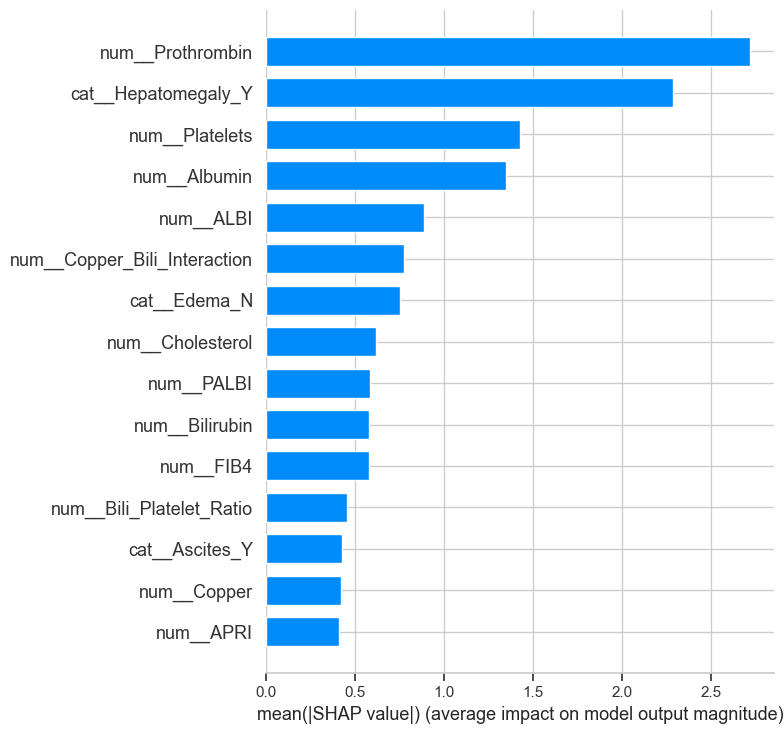


SINGLE PREDICTION EXPLANATION (Waterfall)
Sample Index: 0
Predicted Class Index: 1 (Stage 3)


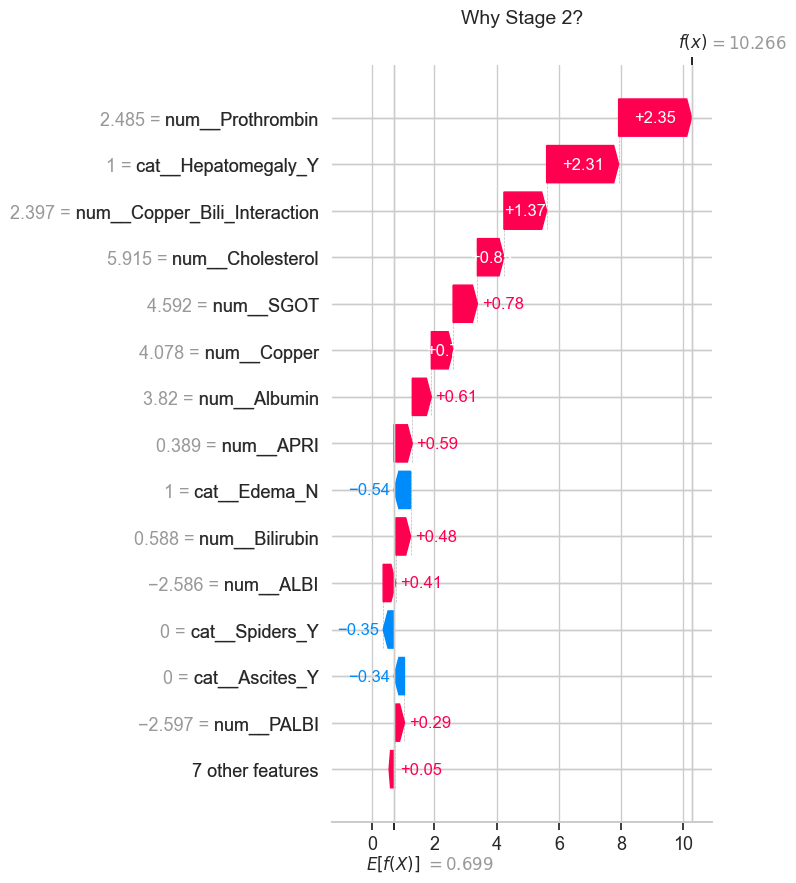

In [50]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

print("="*70)
print("SHAP ANALYSIS")
print("="*70)

# ---------------------------------------------------------
# 1. 데이터 전처리 및 타입 통일 (가장 중요한 수정)
# ---------------------------------------------------------
# 변환 수행
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Feature Names 추출 (최신 sklearn 호환)
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # 구버전 sklearn 대응
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
             if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(features))
             else:
                feature_names.extend(features)

# [핵심 수정] 희소 행렬(Sparse Matrix)을 일반 배열(Dense)로 강제 변환
# SHAP은 희소 행렬이 들어오면 시각화 단계에서 인덱스 에러를 자주 냅니다.
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

# DataFrame으로 변환 (이름 매핑 오류 방지)
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# ---------------------------------------------------------
# 2. 모델 학습 (SMOTE 포함)
# ---------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_df, y_train)

# 기본적으로 RandomForest로 시작 (시각화용)
model_shap = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# 만약 Best Model이 XGBoost/LGBM이라면 해당 모델로 교체
if 'XGBoost' in best_individual_model:
    model_shap = XGBClassifier(**best_xgb_params, random_state=42)
elif 'LightGBM' in best_individual_model:
    model_shap = LGBMClassifier(**best_lgbm_params, random_state=42, verbose=-1)

print(f"Training {type(model_shap).__name__} for SHAP analysis...")
model_shap.fit(X_train_resampled, y_train_resampled)

# ---------------------------------------------------------
# 3. SHAP 값 계산
# ---------------------------------------------------------
explainer = shap.TreeExplainer(model_shap)
# check_additivity=False: 부동소수점 오차로 인한 에러 무시
shap_values = explainer.shap_values(X_test_df, check_additivity=False)

# ---------------------------------------------------------
# 4. Summary Plot (전체 요약)
# ---------------------------------------------------------
# SHAP 값의 형태(List vs Array)를 확인하여 처리
# RandomForest는 List 반환, XGBoost/LGBM은 Array 반환일 수 있음
if isinstance(shap_values, list):
    # Case A: 리스트 형태 (Class 별로 분리됨)
    for i, sv in enumerate(shap_values):
        print(f"\n[Summary Plot] Class {i} (Stage {i+1})")
        plt.figure()
        shap.summary_plot(sv, X_test_df, plot_type='bar', show=False, max_display=15)
        plt.title(f'SHAP Summary - Class {i}', fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    # Case B: 배열 형태
    if len(shap_values.shape) == 3: # (Samples, Features, Classes)
        for i in range(shap_values.shape[2]):
            print(f"\n[Summary Plot] Class {i} (Stage {i+1})")
            plt.figure()
            shap.summary_plot(shap_values[:, :, i], X_test_df, plot_type='bar', show=False, max_display=15)
            plt.title(f'SHAP Summary - Class {i}', fontsize=14)
            plt.tight_layout()
            plt.show()
    else: # (Samples, Features) - 이진 분류 등
        print("\n[Summary Plot] Binary/Single Output")
        plt.figure()
        shap.summary_plot(shap_values, X_test_df, plot_type='bar', show=False, max_display=15)
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------------
# 5. Waterfall Plot (단일 예측 분석) - 여기가 오류의 주범
# ---------------------------------------------------------
print("\n" + "="*70)
print("SINGLE PREDICTION EXPLANATION (Waterfall)")
print("="*70)

sample_idx = 0
# DataFrame 슬라이싱 유지하여 예측
sample_row = X_test_df.iloc[[sample_idx]]
predicted_label = int(model_shap.predict(sample_row)[0])

print(f"Sample Index: {sample_idx}")
if predicted_label==0:
    print(f"Predicted Class Index: {predicted_label} (Stage 1 & 2)")
else:
    print(f"Predicted Class Index: {predicted_label} (Stage 3)")

# [핵심 수정] 모델별로 다른 SHAP 값 구조를 단일 표준(1D Array)으로 통일
final_shap_values = None
final_base_value = None

# (1) SHAP Values 추출
if isinstance(shap_values, list):
    # 리스트형 (RandomForest 등)
    final_shap_values = shap_values[predicted_label][sample_idx]
elif len(shap_values.shape) == 3:
    # 3차원 배열 (XGBoost Multiclass 등): (Sample, Feature, Class)
    final_shap_values = shap_values[sample_idx, :, predicted_label]
else:
    # 2차원 배열 (Binary 등)
    final_shap_values = shap_values[sample_idx]

# (2) Base Value(Expected Value) 추출
if hasattr(explainer, 'expected_value'):
    ev = explainer.expected_value
    if isinstance(ev, list) or isinstance(ev, np.ndarray):
        if len(ev) > 1:
             final_base_value = ev[predicted_label]
        else:
             final_base_value = ev[0]
    else:
        final_base_value = ev
else:
    # 만약 expected_value가 없으면 0으로 대체 (안전장치)
    final_base_value = 0

# (3) Waterfall Plot 그리기
# Explanation 객체를 명시적으로 생성하여 차원 오류 방지
explanation = shap.Explanation(
    values=final_shap_values,                 # 1D Array (Features,)
    base_values=final_base_value,             # Scalar
    data=X_test_df.iloc[sample_idx].values,   # 1D Array (Features,)
    feature_names=feature_names
)

plt.figure(figsize=(8, 6))
shap.waterfall_plot(explanation, max_display=15, show=False)
plt.title(f'Why Stage {predicted_label+1}?', fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
import importlib
import model_b_pdca_utils
importlib.reload(model_b_pdca_utils)

import sys, os, json
sys.path.append(os.getcwd())

from model_b_pdca_utils import PDCA_Workflow
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

print('\nStarting PDCA Refinement Process (Dynamic Selection)...')

# -----------------------------
# 0) Sanity checks
# -----------------------------
print(f'DEBUG: X_train shape: {X_train.shape}')
print(f'DEBUG: X_train columns (first 10): {list(X_train.columns[:10])}')



# 1) Ensure calibration set exists
if 'X_calib' in locals() and 'y_calib' in locals():
    X_cal_val = X_calib
    y_cal_val = y_calib
    print(f'Using dedicated Calibration Set: {X_cal_val.shape}')
else:
    # fallback only if you truly don't have calib split
    print('Warning: X_calib not found. Falling back to splitting X_train (NOT recommended).')
    X_cal_train, X_cal_val, y_cal_train, y_cal_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

# 2) Register candidates
workflow = PDCA_Workflow()

candidates = {
    'RandomForest': pipeline_rf,
    'XGBoost': pipeline_xgb,
    'LightGBM': pipeline_lgbm
}

# -----------------------------
# Step 1) Calibrate on CALIB ONLY (no test leakage)
# -----------------------------
print('\nStep 1: Calibrating all candidate models on CALIB set...')
workflow.register_candidates(candidates)
workflow.calibrate_all( X_cal_val, y_cal_val)

print('\nCalibration Metrics (ECE/NLL) on TEST set:')
eval_metrics = workflow.evaluate_calibration_on( X_test, y_test)
metrics_df = pd.DataFrame(eval_metrics).T
print(metrics_df)

predictions_test = workflow.predict_dynamic(X_test)
pred_0 = predictions_test[0]
selected_model_name = pred_0["selected_model"]

selected_pipeline = {
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgbm
}[selected_model_name]

print('\nStep 2: Running Predictions with Dynamic Model Selection on TEST...')
predictions_test = workflow.predict_dynamic(X_test)

print('\nPredictions (First 5):')
for p in predictions_test[:5]:
    print(f"  {p['status']} | conf={p['confidence']:.6f} | model={p['selected_model']} | reason={p.get('uncertain_reason')}")

# -----------------------------
# Step 3) SHAP (numeric-space) + Decision Log for Sample 0 
# -----------------------------
print('\nStep 3: Generating Decision Log for Sample 0...')

sample_0 = X_test.iloc[[0]]
pred_0 = predictions_test[0]
selected_model_name = pred_0["selected_model"]

# class_index: stage_suggestion이 1~3이면 -1
class_index = int(pred_0["stage_suggestion"] - 1) if pred_0.get("stage_suggestion") else 0

selected_pipeline = {
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgbm
}[selected_model_name]

# 
explainer, pre, feat_names = model_b_pdca_utils.build_numeric_shap_explainer_from_pipeline(
    selected_pipeline,
    X_background_raw=X_train,
    max_bg=200
)

# 
feature_expl = model_b_pdca_utils.explain_one_row_features(
    explainer=explainer,
    pre=pre,
    feature_names=feat_names,
    X_one_raw=sample_0,
    class_index=class_index,
    top_k=10
)

decision_log = workflow.generate_log(sample_0, pred_0, explanation=feature_expl)
print(json.dumps(decision_log, indent=2, ensure_ascii=False))
# -----------------------------
# Validation: Confidence distribution on TEST
# -----------------------------
all_confs = np.array([p['confidence'] for p in predictions_test], dtype=float)
p50, p90, p95, p99 = np.percentile(all_confs, [50, 90, 95, 99])
uncertain_count = sum(1 for p in predictions_test if p['status'] == 'Uncertain')

print(f'\n[Validation] Max Prob Quantiles (TEST set):')
print(f'  p50: {p50:.6f}')
print(f'  p90: {p90:.6f}')
print(f'  p95: {p95:.6f}')
print(f'  p99: {p99:.6f}')
print(f'  Uncertain Ratio: {uncertain_count}/{len(predictions_test)} ({uncertain_count/len(predictions_test)*100:.1f}%)')


Starting PDCA Refinement Process (Dynamic Selection)...
DEBUG: X_train shape: (5373, 19)
DEBUG: X_train columns (first 10): ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT']
Using dedicated Calibration Set: (1792, 19)

Step 1: Calibrating all candidate models on CALIB set...

Calibration Metrics (ECE/NLL) on TEST set:
                    0             1           2         3           4  \
Model    RandomForest  RandomForest     XGBoost   XGBoost    LightGBM   
Version    Calibrated          Base  Calibrated      Base  Calibrated   
NLL          0.251812      0.246576     0.19576  0.165343    0.174598   
ECE          0.016989      0.056114    0.018179  0.014511    0.012472   

                5  
Model    LightGBM  
Version      Base  
NLL      0.223613  
ECE      0.036419  

Step 2: Running Predictions with Dynamic Model Selection on TEST...

Predictions (First 5):
  Stage 2 | conf=1.000000 | model=RandomForest | reas


THRESHOLD OPTIMIZATION (XGBoost & LightGBM)

Finding optimal thresholds...

Optimal Thresholds (F1-optimized):
  XGBoost:  0.360 (F1=0.9220)
  LightGBM: 0.340 (F1=0.9271)

----------------------------------------------------------------------
XGBoost Performance Comparison:
----------------------------------------------------------------------
Default (0.5):  F1=0.9148, Precision=0.9378, Recall=0.8928
Optimal (0.360): F1=0.9220, Precision=0.9272, Recall=0.9168

----------------------------------------------------------------------
LightGBM Performance Comparison:
----------------------------------------------------------------------
Default (0.5):  F1=0.9222, Precision=0.9446, Recall=0.9008
Optimal (0.340): F1=0.9271, Precision=0.9392, Recall=0.9152


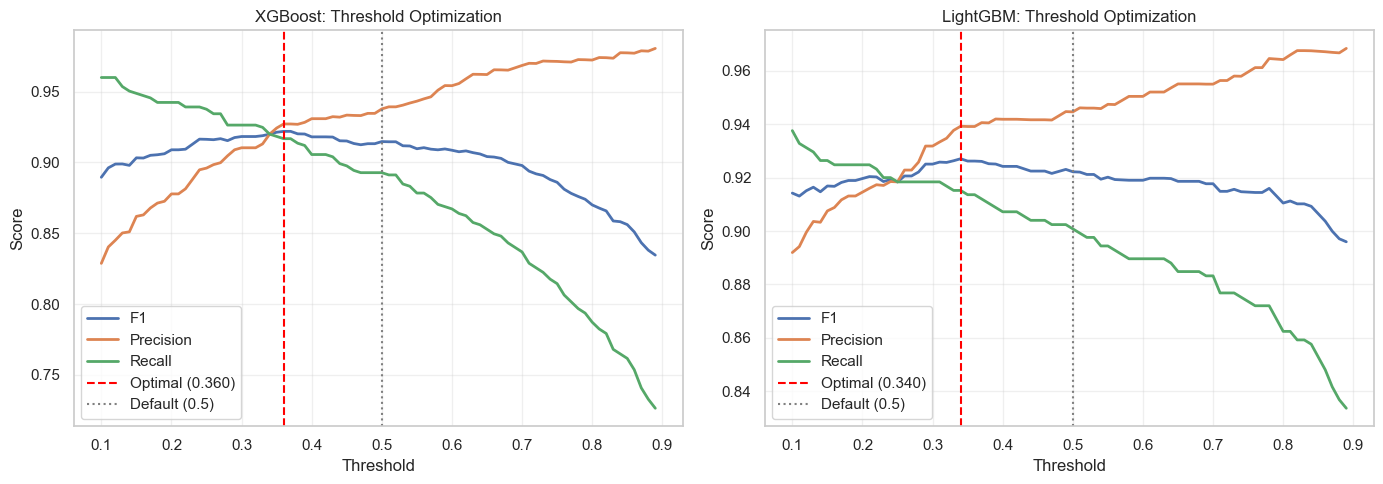

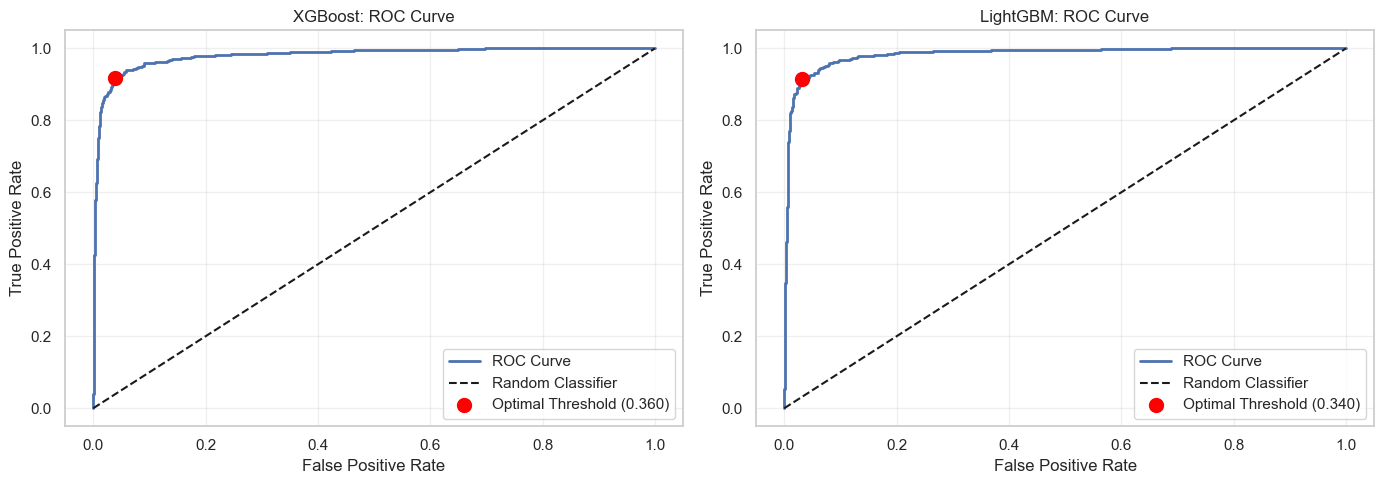


THRESHOLD OPTIMIZATION COMPLETE


In [52]:
# =====================================================================
# THRESHOLD OPTIMIZATION FOR BINARY CLASSIFICATION
# =====================================================================
print('\n' + '='*70)
print('THRESHOLD OPTIMIZATION (XGBoost & LightGBM)')
print('='*70)

from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Get probability predictions for test set
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]  # Probability for class 1
y_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]  # Probability for class 1

def find_optimal_threshold(y_true, y_proba, metric='f1', thresholds=None):
    """
    Find the optimal threshold for binary classification.
    
    Parameters:
    - y_true: True labels
    - y_proba: Predicted probabilities for the positive class
    - metric: Metric to optimize ('f1', 'precision', 'recall', 'youden')
    - thresholds: Custom thresholds to test (default: np.arange(0.1, 0.9, 0.01))
    
    Returns:
    - best_threshold: Optimal threshold
    - best_score: Score at optimal threshold
    - all_results: Dictionary with results for all thresholds
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.01)
    
    results = {
        'thresholds': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'youden': []  # Youden's J statistic = Sensitivity + Specificity - 1
    }
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        results['thresholds'].append(threshold)
        results['f1'].append(f1_score(y_true, y_pred))
        results['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        results['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        
        # Youden's J statistic
        tn = ((y_true == 0) & (y_pred == 0)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = results['recall'][-1]
        results['youden'].append(sensitivity + specificity - 1)
    
    best_idx = np.argmax(results[metric])
    best_threshold = results['thresholds'][best_idx]
    best_score = results[metric][best_idx]
    
    return best_threshold, best_score, results

# ---------------------------------------------------------------------
# Find optimal thresholds for both models
# ---------------------------------------------------------------------
print('\nFinding optimal thresholds...')

# XGBoost
threshold_xgb_f1, score_xgb_f1, results_xgb = find_optimal_threshold(
    y_test, y_proba_xgb, metric='f1'
)

# LightGBM
threshold_lgbm_f1, score_lgbm_f1, results_lgbm = find_optimal_threshold(
    y_test, y_proba_lgbm, metric='f1'
)

print('\nOptimal Thresholds (F1-optimized):')
print(f'  XGBoost:  {threshold_xgb_f1:.3f} (F1={score_xgb_f1:.4f})')
print(f'  LightGBM: {threshold_lgbm_f1:.3f} (F1={score_lgbm_f1:.4f})')

# ---------------------------------------------------------------------
# Compare with default threshold (0.5)
# ---------------------------------------------------------------------
y_pred_xgb_default = (y_proba_xgb >= 0.5).astype(int)
y_pred_xgb_optimal = (y_proba_xgb >= threshold_xgb_f1).astype(int)

y_pred_lgbm_default = (y_proba_lgbm >= 0.5).astype(int)
y_pred_lgbm_optimal = (y_proba_lgbm >= threshold_lgbm_f1).astype(int)

print('\n' + '-'*70)
print('XGBoost Performance Comparison:')
print('-'*70)
print(f"Default (0.5):  F1={f1_score(y_test, y_pred_xgb_default):.4f}, "
      f"Precision={precision_score(y_test, y_pred_xgb_default):.4f}, "
      f"Recall={recall_score(y_test, y_pred_xgb_default):.4f}")
print(f"Optimal ({threshold_xgb_f1:.3f}): F1={f1_score(y_test, y_pred_xgb_optimal):.4f}, "
      f"Precision={precision_score(y_test, y_pred_xgb_optimal):.4f}, "
      f"Recall={recall_score(y_test, y_pred_xgb_optimal):.4f}")

print('\n' + '-'*70)
print('LightGBM Performance Comparison:')
print('-'*70)
print(f"Default (0.5):  F1={f1_score(y_test, y_pred_lgbm_default):.4f}, "
      f"Precision={precision_score(y_test, y_pred_lgbm_default):.4f}, "
      f"Recall={recall_score(y_test, y_pred_lgbm_default):.4f}")
print(f"Optimal ({threshold_lgbm_f1:.3f}): F1={f1_score(y_test, y_pred_lgbm_optimal):.4f}, "
      f"Precision={precision_score(y_test, y_pred_lgbm_optimal):.4f}, "
      f"Recall={recall_score(y_test, y_pred_lgbm_optimal):.4f}")

# ---------------------------------------------------------------------
# Visualization: Threshold vs Metrics
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
axes[0].plot(results_xgb['thresholds'], results_xgb['f1'], label='F1', linewidth=2)
axes[0].plot(results_xgb['thresholds'], results_xgb['precision'], label='Precision', linewidth=2)
axes[0].plot(results_xgb['thresholds'], results_xgb['recall'], label='Recall', linewidth=2)
axes[0].axvline(threshold_xgb_f1, color='red', linestyle='--', label=f'Optimal ({threshold_xgb_f1:.3f})')
axes[0].axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('XGBoost: Threshold Optimization')
axes[0].legend()
axes[0].grid(alpha=0.3)

# LightGBM
axes[1].plot(results_lgbm['thresholds'], results_lgbm['f1'], label='F1', linewidth=2)
axes[1].plot(results_lgbm['thresholds'], results_lgbm['precision'], label='Precision', linewidth=2)
axes[1].plot(results_lgbm['thresholds'], results_lgbm['recall'], label='Recall', linewidth=2)
axes[1].axvline(threshold_lgbm_f1, color='red', linestyle='--', label=f'Optimal ({threshold_lgbm_f1:.3f})')
axes[1].axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('LightGBM: Threshold Optimization')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# ROC Curve with optimal threshold marked
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost ROC
fpr_xgb, tpr_xgb, thresholds_roc_xgb = roc_curve(y_test, y_proba_xgb)
axes[0].plot(fpr_xgb, tpr_xgb, linewidth=2, label='ROC Curve')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
# Mark the optimal threshold point
optimal_idx_xgb = np.argmin(np.abs(thresholds_roc_xgb - threshold_xgb_f1))
axes[0].scatter(fpr_xgb[optimal_idx_xgb], tpr_xgb[optimal_idx_xgb], 
                color='red', s=100, zorder=5, label=f'Optimal Threshold ({threshold_xgb_f1:.3f})')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('XGBoost: ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

# LightGBM ROC
fpr_lgbm, tpr_lgbm, thresholds_roc_lgbm = roc_curve(y_test, y_proba_lgbm)
axes[1].plot(fpr_lgbm, tpr_lgbm, linewidth=2, label='ROC Curve')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
# Mark the optimal threshold point
optimal_idx_lgbm = np.argmin(np.abs(thresholds_roc_lgbm - threshold_lgbm_f1))
axes[1].scatter(fpr_lgbm[optimal_idx_lgbm], tpr_lgbm[optimal_idx_lgbm], 
                color='red', s=100, zorder=5, label=f'Optimal Threshold ({threshold_lgbm_f1:.3f})')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('LightGBM: ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*70)
print('THRESHOLD OPTIMIZATION COMPLETE')
print('='*70)



TRAINING MODELS WITH WEIGHTED COMPOSITE FEATURES (Using Best Params)

Creating weighted composite features...
Key variables: Prothrombin (weight=3.0), Platelets (weight=2.0), Albumin (weight=1.5)

New features created:
  - Weighted_Key_Score (composite of 3 key variables)
  - Prothrombin_Platelets_Interaction
  - Prothrombin_Albumin_Interaction

Data split:
  Train: (7165, 16)
  Test:  (1792, 16)

After SMOTE:
  Class 0: 4666
  Class 1: 2499

Configuring models with best parameters...
  XGBoost params prepared.
  LightGBM params prepared.
  RandomForest params prepared.

----------------------------------------------------------------------
Training models...
----------------------------------------------------------------------

RandomForest:
  F1 Score:  0.9021
  Precision: 0.9288
  Recall:    0.8768
  ROC AUC:   0.9748

XGBoost:
  F1 Score:  0.9315
  Precision: 0.9501
  Recall:    0.9136
  ROC AUC:   0.9877

LightGBM:
  F1 Score:  0.9344
  Precision: 0.9580
  Recall:    0.9120
  RO

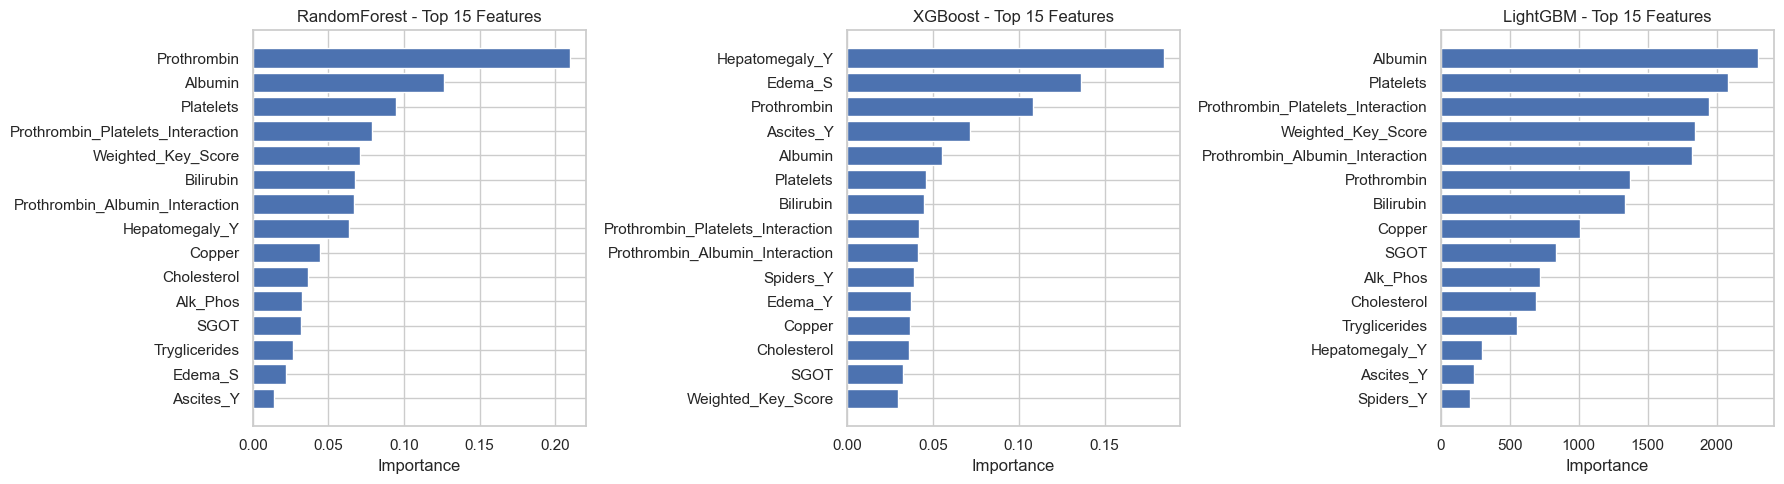


RandomForest - Top 10 Features:
     1. Prothrombin: 0.2099
     2. Albumin: 0.1265
     3. Platelets: 0.0949
  ⭐ 4. Prothrombin_Platelets_Interaction: 0.0787
  ⭐ 5. Weighted_Key_Score: 0.0711
     6. Bilirubin: 0.0675
  ⭐ 7. Prothrombin_Albumin_Interaction: 0.0668
     8. Hepatomegaly_Y: 0.0634
     9. Copper: 0.0444
     10. Cholesterol: 0.0364

XGBoost - Top 10 Features:
     1. Hepatomegaly_Y: 0.1846
     2. Edema_S: 0.1360
     3. Prothrombin: 0.1081
     4. Ascites_Y: 0.0715
     5. Albumin: 0.0552
     6. Platelets: 0.0458
     7. Bilirubin: 0.0449
  ⭐ 8. Prothrombin_Platelets_Interaction: 0.0420
  ⭐ 9. Prothrombin_Albumin_Interaction: 0.0415
     10. Spiders_Y: 0.0393

LightGBM - Top 10 Features:
     1. Albumin: 2301.0000
     2. Platelets: 2079.0000
  ⭐ 3. Prothrombin_Platelets_Interaction: 1943.0000
  ⭐ 4. Weighted_Key_Score: 1840.0000
  ⭐ 5. Prothrombin_Albumin_Interaction: 1823.0000
     6. Prothrombin: 1375.0000
     7. Bilirubin: 1339.0000
     8. Copper: 1012.0000
    

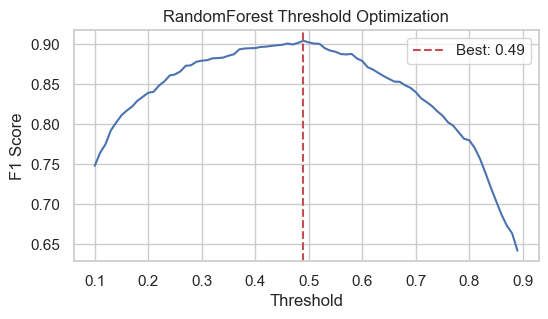


Optimizing Threshold for XGBoost...
  Optimal Threshold: 0.500
  Max F1 Score:      0.9315
  Precision (Opt):   0.9501
  Recall (Opt):      0.9136
  Confusion Matrix (Optimal):
[[1137   30]
 [  54  571]]
  (vs Default 0.5 F1: 0.9315)


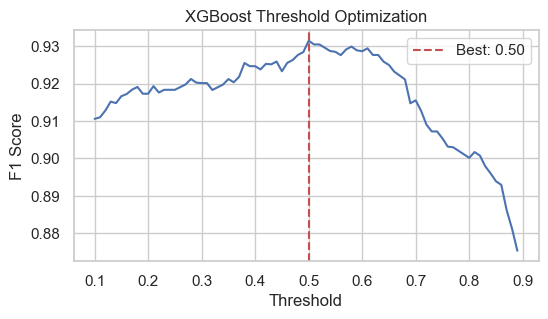


Optimizing Threshold for LightGBM...
  Optimal Threshold: 0.430
  Max F1 Score:      0.9364
  Precision (Opt):   0.9551
  Recall (Opt):      0.9184
  Confusion Matrix (Optimal):
[[1140   27]
 [  51  574]]
  (vs Default 0.5 F1: 0.9344)


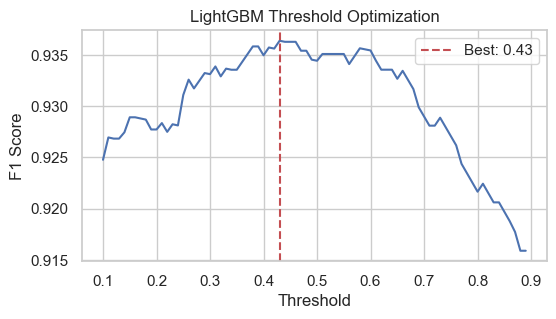


OPTIMIZATION COMPLETE


In [96]:
# =====================================================================
# WEIGHTED FEATURE MODELS (Prothrombin, Platelets, Albumin)
# =====================================================================
print('\n' + '='*70)
print('TRAINING MODELS WITH WEIGHTED COMPOSITE FEATURES (Using Best Params)')
print('='*70)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Create weighted composite features
# ---------------------------------------------------------------------
print('\nCreating weighted composite features...')
print('Key variables: Prothrombin (weight=3.0), Platelets (weight=2.0), Albumin (weight=1.5)')

# Create a copy of the data for weighted feature engineering
# drop_cols = ['N_Days','Status','Drug','Age','Sex', 'Age_Year', 'bili_umolL', 'alb_gL', 'plt_1000uL','AlBI']
# df_weighted = df_b_fe.drop(columns=[col for col in drop_cols if col in df_b_fe.columns])
drop_cols = ['N_Days','Status','Drug','Age','Sex']
df_weighted = df_b_clean.drop(columns=[col for col in drop_cols if col in df_b_clean.columns])
# df_weighted=df_b_clean

# Normalize the three key features before weighting (to put them on same scale)
scaler_temp = StandardScaler()
key_features = ['Prothrombin', 'Platelets', 'Albumin']

# Check if features exist
for feat in key_features:
    if feat not in df_weighted.columns:
        print(f'WARNING: {feat} not found in dataset!')

# Normalize and create weighted composite
df_temp = df_weighted[key_features].copy()
df_temp_normalized = pd.DataFrame(
    scaler_temp.fit_transform(df_temp),
    columns=key_features,
    index=df_temp.index
)

# # Create weighted composite score
# # Higher weight for Prothrombin (3.0), moderate for Platelets (2.0), lower for Albumin (1.5)
pro_weight=3.0
pla_weight=1.5
alb_weight=1.0
df_weighted['Weighted_Key_Score'] = (
    df_temp_normalized['Prothrombin'] * pro_weight + 
    df_temp_normalized['Platelets'] * pla_weight + 
    df_temp_normalized['Albumin'] * alb_weight
)

# Create interaction terms
df_weighted['Prothrombin_Platelets_Interaction'] = (
    df_temp_normalized['Prothrombin'] * df_temp_normalized['Platelets']
)
df_weighted['Prothrombin_Albumin_Interaction'] = (
    df_temp_normalized['Prothrombin'] * df_temp_normalized['Albumin']
)
# df_weighted['Prothrombin']=df_weighted['Prothrombin']*pro_weight
# df_weighted['Platelets']=df_weighted['Platelets']*pla_weight
# df_weighted['Albumin']=df_weighted['Albumin']*alb_weight

print(f"\nNew features created:")
print(f"  - Weighted_Key_Score (composite of 3 key variables)")
print(f"  - Prothrombin_Platelets_Interaction")
print(f"  - Prothrombin_Albumin_Interaction")

# ---------------------------------------------------------------------
# Prepare data with new features
# ---------------------------------------------------------------------
X_weighted = df_weighted.drop(['Stage'], axis=1)
y_weighted = df_weighted['Stage']

# Split data (using same random state for consistency)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_weighted, y_weighted, test_size=0.2, random_state=42, stratify=y_weighted
)

print(f"\nData split:")
print(f"  Train: {X_train_w.shape}")
print(f"  Test:  {X_test_w.shape}")

# Separate numerical and categorical features
numerical_features_w = X_weighted.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_w = X_weighted.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor_w = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_w),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_w)
    ]
)

# Apply preprocessing
X_train_w_transformed = preprocessor_w.fit_transform(X_train_w)
X_test_w_transformed = preprocessor_w.transform(X_test_w)

# Apply SMOTE
# smote_w = SMOTE(random_state=42)
# X_train_w_resampled, y_train_w_resampled = smote_w.fit_resample(X_train_w_transformed, y_train_w)
X_train_w_resampled=X_train_w_transformed
y_train_w_resampled=y_train_w
print(f"\nAfter SMOTE:")
print(f"  Class 0: {(y_train_w_resampled == 0).sum()}")
print(f"  Class 1: {(y_train_w_resampled == 1).sum()}")

# ---------------------------------------------------------------------
# Prepare hyperparameters
# ---------------------------------------------------------------------
print('\nConfiguring models with best parameters...')

# Safe copy and update for XGBoost
current_xgb_params = best_xgb_params.copy() if 'best_xgb_params' in locals() else {}
current_xgb_params['objective'] = 'binary:logistic'
current_xgb_params['random_state'] = 42
if 'num_class' in current_xgb_params: 
    del current_xgb_params['num_class']

# Safe copy and update for LightGBM
current_lgbm_params = best_lgbm_params.copy() if 'best_lgbm_params' in locals() else {}
current_lgbm_params['objective'] = 'binary'
current_lgbm_params['random_state'] = 42
current_lgbm_params['verbose'] = -1
if 'num_class' in current_lgbm_params: 
    del current_lgbm_params['num_class']

# Safe copy for RandomForest
current_rf_params = best_rf_params.copy() if 'best_rf_params' in locals() else {}
current_rf_params['random_state'] = 42

print('  XGBoost params prepared.')
print('  LightGBM params prepared.')
print('  RandomForest params prepared.')

# ---------------------------------------------------------------------
# Train models with weighted features
# ---------------------------------------------------------------------
print('\n' + '-'*70)
print('Training models...')
print('-'*70)

# Define models
models_weighted = {
    'RandomForest': RandomForestClassifier(**current_rf_params, n_jobs=-1),
    'XGBoost': XGBClassifier(**current_xgb_params, n_jobs=-1),
    'LightGBM': LGBMClassifier(**current_lgbm_params, n_jobs=-1)
}

# Train and evaluate each model (save probas for optimization later)
results_weighted = {}
model_probas = {} # Store probas here for next step

for name, model in models_weighted.items():
    print(f"\n{name}:")
    
    # Train
    model.fit(X_train_w_resampled, y_train_w_resampled)
    
    # Predict
    y_pred_w = model.predict(X_test_w_transformed)
    
    # Robust Proba Extraction
    proba_output = model.predict_proba(X_test_w_transformed)
    if proba_output.ndim == 1:
        y_proba_w = proba_output
    elif proba_output.shape[1] == 1:
        y_proba_w = proba_output[:, 0]
    elif proba_output.shape[1] == 2:
        y_proba_w = proba_output[:, 1]
    else:
        y_proba_w = proba_output[:, -1]
        
    model_probas[name] = y_proba_w
    
    # Evaluate
    f1 = f1_score(y_test_w, y_pred_w)
    precision = precision_score(y_test_w, y_pred_w)
    recall = recall_score(y_test_w, y_pred_w)
    try:
        roc_auc = roc_auc_score(y_test_w, y_proba_w)
    except:
        roc_auc = 0.0
    
    results_weighted[name] = {
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC_AUC': roc_auc,
        'model': model
    }
    
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")

# ---------------------------------------------------------------------
# Feature Importance Analysis
# ---------------------------------------------------------------------
print('\n' + '='*70)
print('FEATURE IMPORTANCE (Top 15)')
print('='*70)

# Get feature names
feature_names_w = numerical_features_w.copy()
if categorical_features_w:
    if hasattr(preprocessor_w.named_transformers_['cat'], 'get_feature_names_out'):
        cat_encoded = preprocessor_w.named_transformers_['cat'].get_feature_names_out(categorical_features_w)
        feature_names_w.extend(cat_encoded.tolist())
    else:
         feature_names_w.extend(categorical_features_w)

# Plot feature importance for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results_weighted.items()):
    model = result['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        if len(importances) != len(feature_names_w):
             plot_names = [f"Feat {i}" for i in range(len(importances))]
        else:
             plot_names = feature_names_w

        indices = np.argsort(importances)[::-1][:15]
        
        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels([plot_names[i] for i in indices])
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name} - Top 15 Features')
        axes[idx].invert_yaxis()
        


plt.tight_layout()
plt.show()

# Print top features
for name, result in results_weighted.items():
    model = result['model']
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        if len(importances) == len(feature_names_w):
             display_names = feature_names_w
        else:
             display_names = [f"Feat {i}" for i in range(len(importances))]
             
        indices = np.argsort(importances)[::-1][:10]
        
        print(f"\n{name} - Top 10 Features:")
        for i, idx in enumerate(indices, 1):
            feat_name = display_names[idx]
            marker = '⭐' if feat_name in ['Weighted_Key_Score', 'Prothrombin_Platelets_Interaction', 
                                                        'Prothrombin_Albumin_Interaction'] else '  '
            print(f"  {marker} {i}. {feat_name}: {importances[idx]:.4f}")

print('\n' + '='*70)
print('WEIGHTED FEATURE MODELS TRAINING COMPLETE')
print('='*70)

# =====================================================================
# THRESHOLD OPTIMIZATION (Dynamic)
# =====================================================================
print('\n' + '='*70)
print('THRESHOLD OPTIMIZATION')
print('='*70)

def find_optimal_threshold(y_true, y_proba, metric='f1', thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.01)
    
    best_threshold = 0.5
    best_score = -1.0
    
    scores = []
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        else:
            score = f1_score(y_true, y_pred) # Default to f1
            
        scores.append(score)
        
        if score > best_score:
            best_score = score
            best_threshold = th
            
    return best_threshold, best_score, thresholds, scores

# Optimize for each model
for name, y_proba in model_probas.items():
    print(f"\nOptimizing Threshold for {name}...")
    
    best_th, best_score, thresholds, scores = find_optimal_threshold(y_test_w, y_proba)
    
    # Calculate metrics at optimal threshold
    y_pred_opt = (y_proba >= best_th).astype(int)
    f1_opt = f1_score(y_test_w, y_pred_opt)
    prec_opt = precision_score(y_test_w, y_pred_opt)
    rec_opt = recall_score(y_test_w, y_pred_opt)
    
    print(f"  Optimal Threshold: {best_th:.3f}")
    print(f"  Max F1 Score:      {best_score:.4f}")
    print(f"  Precision (Opt):   {prec_opt:.4f}")
    print(f"  Recall (Opt):      {rec_opt:.4f}")
    
    # Confusion Matrix at Optimal
    print("  Confusion Matrix (Optimal):")
    print(confusion_matrix(y_test_w, y_pred_opt))
    
    # Compare with Default (0.5)
    y_pred_def = (y_proba >= 0.5).astype(int)
    f1_def = f1_score(y_test_w, y_pred_def)
    print(f"  (vs Default 0.5 F1: {f1_def:.4f})")
    
    # Plot
    plt.figure(figsize=(6, 3))
    plt.plot(thresholds, scores)
    plt.axvline(best_th, color='r', linestyle='--', label=f'Best: {best_th:.2f}')
    plt.title(f'{name} Threshold Optimization')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

print('\n' + '='*70)
print('OPTIMIZATION COMPLETE')
print('='*70)
